# Model Implementation
- Decision Trees. For the decision tree, you should implement or steal a decision tree algorithm (and by
"implement or steal" I mean "steal"). Be sure to use some form of pruning. You are not required to use
information gain (for example, there is something called the GINI index that is sometimes used) to split
attributes, but you should describe whatever it is that you do use.
- Neural Networks. For the neural network you should implement or steal your favorite kind of network
and training algorithm. You may use networks of nodes with as many layers as you like and any
activation function you see fit.
- Boosting. Implement or steal a boosted version of your decision trees. As before, you will want to use
some form of pruning, but presumably because you're using boosting you can afford to be much more
aggressive about your pruning.
- Support Vector Machines. You should implement (for sufficiently loose definitions of implement
including "download") SVMs. This should be done in such a way that you can swap out kernel functions.
I'd like to see at least two.
- k-Nearest Neighbors. You should "implement" (the quotes mean I don't mean it: steal the code) kNN.
Use different values of k.
- Testing. In addition to implementing (wink) the algorithms described above, you should design two
interesting classification problems. For the purposes of this assignment, a classification problem is just a
set of training examples and a set of test examples. I don't care where you get the data. You can
download some, take some from your own research, or make some up on your own. Be careful about
the data you choose, though. You'll have to explain why they are interesting, use them in later
assignments, and come to really care about them.

In [ ]:
def decision_tree()

# Problem 1: Sleep stage classification using ECG signal

In [2]:
import os
from os import walk

from collections import defaultdict

import numpy as np
import matplotlib.pyplot as plt

import mne
from mne.datasets.sleep_physionet.age import fetch_data
from mne.time_frequency import psd_welch

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer

In [101]:
%matplotlib notebook

In [20]:
import itertools

In [3]:
PROJECT_PATH = "/Users/hoyu/hong/omscs/cs7641/cs7641-sl"
data_path = os.path.join(PROJECT_PATH, 'data')
raw_data_path = os.path.join(data_path, "raw", "sleep-edf-database-expanded-1.0.0","sleep-cassette")
# '/home/hong/physionet.org/files/sleep-edfx/1.0.0/sleep-cassette/'
mapping = {'EOG horizontal': 'eog',
       'Resp oro-nasal': 'misc',
       'EMG submental': 'misc',
       'Temp rectal': 'misc',
       'Event marker': 'misc'}

In [21]:
raw_data_path

'/Users/hoyu/hong/omscs/cs7641/cs7641-sl/data/raw/sleep-edf-database-expanded-1.0.0/sleep-cassette'

In [4]:
# Prepare dataset

def read_raw_and_annotation_data(raw_data_name, annotation_name, should_plot=False):
    '''Returns a raw object and the annotation object.
    Input:
        - raw_data_name: string of raw_data file. Name endedd with PSG.edf.
        - annotation_name: string of annotation file. Name ended with Hypnogram.edf.
        - should_plot: plot the data if set to true for debug purpose.
    '''
    raw_train = mne.io.read_raw_edf(raw_data_name)
    annot_train = mne.read_annotations(annotation_name)

    raw_train.set_annotations(annot_train, emit_warning=False)
    raw_train.set_channel_types(mapping)

    # plot some data
    if should_plot:
        raw_train.plot(duration=60, scalings='auto')
    return raw_train, annot_train
    
def get_rawdata_annotation_filenames(dir):
    '''Returns a dict of all key: (raw_data, annotation) map assuming the first 7 characters are the same.
    '''
    file_pairs = {}
    for (dirpath, dirnames, filenames) in walk(dir):
        break       
    for file in filenames:
        key = file[:7]
        if key not in file_pairs:
            file_pairs[key] = ['', '']
        if file.endswith('Hypnogram.edf'):
            file_pairs[key][1] = file
        elif file.endswith('PSG.edf'):
            file_pairs[key][0] = file
    return file_pairs

In [29]:


event_id = {'Sleep stage W': 1,
            'Sleep stage 1': 2,
            'Sleep stage 2': 3,
#             'Sleep stage 3': 4,
#             'Sleep stage 4': 4,
            'Sleep stage R': 5}
event_id_1 = {'Sleep stage W': 1,
              'Sleep stage 1': 2,
              'Sleep stage 2': 3,
#                   'Sleep stage 3/4': 4,
              'Sleep stage R': 5}
def extract_events_plot(raw_train, annot_train, chunk_duration):
    events_train, _ = mne.events_from_annotations(
    raw_train, event_id=event_id, chunk_duration=chunk_duration)

    fig = mne.viz.plot_events(events_train, event_id=event_id_1,
                          sfreq=raw_train.info['sfreq'],
                          first_samp=events_train[0, 0])
    stage_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

def extract_epochs(raw_data_name, annotation_name, chunk_duration):
    raw = mne.io.read_raw_edf(raw_data_name)
    annot = mne.read_annotations(annotation_name)
    annot.crop(annot[1]['onset'] - 30 * 60,
               annot[-2]['onset'] + 30 * 60)
    raw.set_annotations(annot, emit_warning=False)
    raw.set_channel_types(mapping)
    
    events, _ = mne.events_from_annotations(
    raw, event_id=event_id, chunk_duration=chunk_duration)
    tmax = 30. - 1. / raw.info['sfreq']  # tmax in included
    epochs = mne.Epochs(raw=raw, events=events,
                        event_id=event_id, tmin=0., tmax=tmax, baseline=None)
    return epochs

In [30]:
epochs_train = extract_epochs(os.path.join(raw_data_path, 'SC4342F0-PSG.edf'), os.path.join(raw_data_path, 'SC4342FA-Hypnogram.edf'), 30)


Extracting EDF parameters from /Users/hoyu/hong/omscs/cs7641/cs7641-sl/data/raw/sleep-edf-database-expanded-1.0.0/sleep-cassette/SC4342F0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage R', 'Sleep stage W']
Not setting metadata
Not setting metadata
1582 matching events found
No baseline correction applied
0 projection items activated


In [35]:
epochs_train[0].__dict__


{'reject_by_annotation': True,
 'verbose': None,
 'event_id': {'Sleep stage W': 1},
 'selection': array([0]),
 'events': array([[861000,      0,      1]]),
 '_metadata': None,
 'drop_log': ((),
  ('IGNORED',),
  ('IGNORED',),
  ('IGNORED',),
  ('IGNORED',),
  ('IGNORED',),
  ('IGNORED',),
  ('IGNORED',),
  ('IGNORED',),
  ('IGNORED',),
  ('IGNORED',),
  ('IGNORED',),
  ('IGNORED',),
  ('IGNORED',),
  ('IGNORED',),
  ('IGNORED',),
  ('IGNORED',),
  ('IGNORED',),
  ('IGNORED',),
  ('IGNORED',),
  ('IGNORED',),
  ('IGNORED',),
  ('IGNORED',),
  ('IGNORED',),
  ('IGNORED',),
  ('IGNORED',),
  ('IGNORED',),
  ('IGNORED',),
  ('IGNORED',),
  ('IGNORED',),
  ('IGNORED',),
  ('IGNORED',),
  ('IGNORED',),
  ('IGNORED',),
  ('IGNORED',),
  ('IGNORED',),
  ('IGNORED',),
  ('IGNORED',),
  ('IGNORED',),
  ('IGNORED',),
  ('IGNORED',),
  ('IGNORED',),
  ('IGNORED',),
  ('IGNORED',),
  ('IGNORED',),
  ('IGNORED',),
  ('IGNORED',),
  ('IGNORED',),
  ('IGNORED',),
  ('IGNORED',),
  ('IGNORED',),
  ('IG

In [ ]:
def epoch_to_vector(epoch):
    

In [ ]:
def eeg_power_band(epochs):
    """EEG relative power band feature extraction.

    This function takes an ``mne.Epochs`` object and creates EEG features based
    on relative power in specific frequency bands that are compatible with
    scikit-learn.

    Parameters
    ----------
    epochs : Epochs
        The data.

    Returns
    -------
    X : numpy array of shape [n_samples, 5]
        Transformed data.
    """
    # specific frequency bands
    FREQ_BANDS = {"delta": [0.5, 4.5],
                  "theta": [4.5, 8.5],
                  "alpha": [8.5, 11.5],
                  "sigma": [11.5, 15.5],
                  "beta": [15.5, 30]}

    psds, freqs = psd_welch(epochs, picks='eeg', fmin=0.5, fmax=30.)
    # Normalize the PSDs
    psds /= np.sum(psds, axis=-1, keepdims=True)

    X = []
    for fmin, fmax in FREQ_BANDS.values():
        psds_band = psds[:, :, (freqs >= fmin) & (freqs < fmax)].mean(axis=-1)
        X.append(psds_band.reshape(len(psds), -1))

    return np.concatenate(X, axis=1)

In [ ]:
# make pipelines
pipe_rf = make_pipeline(FunctionTransformer(eeg_power_band, validate=False),
                     RandomForestClassifier(n_estimators=100, random_state=42))

In [23]:
file_pairs = get_rawdata_annotation_filenames(dir=raw_data_path)


In [24]:
file_pairs

{'SC4411E': ['SC4411E0-PSG.edf', 'SC4411EJ-Hypnogram.edf'],
 'SC4611E': ['SC4611E0-PSG.edf', 'SC4611EG-Hypnogram.edf'],
 'SC4201E': ['SC4201E0-PSG.edf', 'SC4201EC-Hypnogram.edf'],
 'SC4141E': ['SC4141E0-PSG.edf', 'SC4141EU-Hypnogram.edf'],
 'SC4171E': ['SC4171E0-PSG.edf', 'SC4171EU-Hypnogram.edf'],
 'SC4662E': ['SC4662E0-PSG.edf', 'SC4662EJ-Hypnogram.edf'],
 'SC4272F': ['SC4272F0-PSG.edf', 'SC4272FM-Hypnogram.edf'],
 'SC4421E': ['SC4421E0-PSG.edf', 'SC4421EA-Hypnogram.edf'],
 'SC4751E': ['SC4751E0-PSG.edf', 'SC4751EC-Hypnogram.edf'],
 'SC4401E': ['SC4401E0-PSG.edf', 'SC4401EC-Hypnogram.edf'],
 'SC4452F': ['SC4452F0-PSG.edf', 'SC4452FW-Hypnogram.edf'],
 'SC4462F': ['SC4462F0-PSG.edf', 'SC4462FJ-Hypnogram.edf'],
 'SC4432E': ['SC4432E0-PSG.edf', 'SC4432EM-Hypnogram.edf'],
 'SC4542F': ['SC4542F0-PSG.edf', 'SC4542FW-Hypnogram.edf'],
 'SC4821G': ['SC4821G0-PSG.edf', 'SC4821GC-Hypnogram.edf'],
 'SC4622E': ['SC4622E0-PSG.edf', 'SC4622EJ-Hypnogram.edf'],
 'SC4592G': ['SC4592G0-PSG.edf', 'SC4592

In [ ]:

file_pairs = get_rawdata_annotation_filenames(DATA_PATH)
for key, value in file_pairs.items():
    print(value)

Extracting EDF parameters from /Users/hoyu/hong/omscs/cs7641/cs7641-sl/data/raw/sleep-edf-database-expanded-1.0.0/sleep-cassette/SC4342F0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


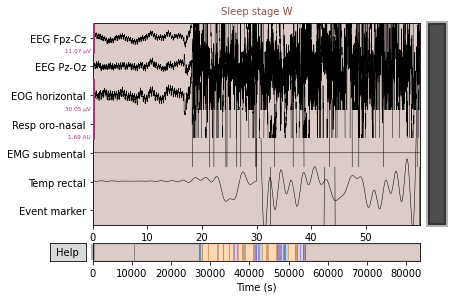

In [25]:

# Plot one pair of file
raw_train_example, annot_train_example = read_raw_and_annotation_data(os.path.join(raw_data_path, 'SC4342F0-PSG.edf'), os.path.join(raw_data_path, 'SC4342FA-Hypnogram.edf'), True)


In [ ]:

training_sets, test_sets = data_split(file_pairs)
print(training_sets)
print(test_sets)

# EDA


## check processed data

# prepare data



In [6]:
from sklearn.utils import Bunch
from sklearn.model_selection import train_test_split
from pathlib import Path

## Load all file names

In [79]:
# file_pairs = get_rawdata_annotation_filenames(dir=raw_data_path)


In [7]:
eeg_data_path = Path(r'/Users/hoyu/hong/omscs/cs7641/cs7641-sl/data/processed/eeg_fpz_cz')
eeg_file_list = list(eeg_data_path.glob('*.npz'))
eeg_file_list

[PosixPath('/Users/hoyu/hong/omscs/cs7641/cs7641-sl/data/processed/eeg_fpz_cz/SC4182E0.npz'),
 PosixPath('/Users/hoyu/hong/omscs/cs7641/cs7641-sl/data/processed/eeg_fpz_cz/SC4652E0.npz'),
 PosixPath('/Users/hoyu/hong/omscs/cs7641/cs7641-sl/data/processed/eeg_fpz_cz/SC4062E0.npz'),
 PosixPath('/Users/hoyu/hong/omscs/cs7641/cs7641-sl/data/processed/eeg_fpz_cz/SC4292G0.npz'),
 PosixPath('/Users/hoyu/hong/omscs/cs7641/cs7641-sl/data/processed/eeg_fpz_cz/SC4582G0.npz'),
 PosixPath('/Users/hoyu/hong/omscs/cs7641/cs7641-sl/data/processed/eeg_fpz_cz/SC4142E0.npz'),
 PosixPath('/Users/hoyu/hong/omscs/cs7641/cs7641-sl/data/processed/eeg_fpz_cz/SC4352F0.npz'),
 PosixPath('/Users/hoyu/hong/omscs/cs7641/cs7641-sl/data/processed/eeg_fpz_cz/SC4482F0.npz'),
 PosixPath('/Users/hoyu/hong/omscs/cs7641/cs7641-sl/data/processed/eeg_fpz_cz/SC4412E0.npz'),
 PosixPath('/Users/hoyu/hong/omscs/cs7641/cs7641-sl/data/processed/eeg_fpz_cz/SC4222E0.npz'),
 PosixPath('/Users/hoyu/hong/omscs/cs7641/cs7641-sl/data/pro

In [29]:
eeg_file_list_small = eeg_file_list[0:5]

## Train, val, test split

In [9]:
def data_split(file_map, seed=0, training_ratio=0.9, cv_fold=5):
    np.random.seed(seed)
    file_count = len(file_map)
    fold_size = int(len(file_map) * training_ratio / cv_fold)
    training_sets = [[] for _ in range(cv_fold)]
    test_sets = []
    for key, (v1, v2) in file_pairs.items():
        if not v1 or not v2:
            continue
        if np.random.random_sample() <= training_ratio:
            for training_fold in training_sets:
                if len(training_fold) < fold_size:
                    training_fold.append(key)
        else:
            test_sets.append(key)
    return training_sets, test_sets

In [ ]:
def train_val_test_split(train_ration, val_ration, test_ratio):
    pass
    

In [ ]:
train_ratio = 0.75
validation_ratio = 0.15
test_ratio = 0.10

# train is now 75% of the entire data set
# the _junk suffix means that we drop that variable completely
x_train, x_test, y_train, y_test = train_test_split(dataX, dataY, test_size=1 - train_ratio)

# test is now 10% of the initial data set
# validation is now 15% of the initial data set
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=test_ratio/(test_ratio + validation_ratio)) 

print(x_train, x_val, x_test)

## File names to sklearn dataset

In [10]:
def create_dataset(file_list, description=""):
    dataset = Bunch()
    data_all = [np.load(fname) for fname in file_list]
    x_all = [np.squeeze(data['x']) for data in data_all]
    y_all = [data['y'] for data in data_all]

    dataset.data = np.concatenate(x_all)
    dataset.target = np.concatenate(y_all)
    dataset.DESCR = description
    dataset.feature_names = [f'time_{t}' for t in range(dataset.data.shape[1])]
    dataset.target_names = ["sleep_stage"]
    return dataset

In [30]:
dataset = create_dataset(file_list = eeg_file_list_small)

In [31]:
train_ratio = 0.8
x_train, x_test, y_train, y_test = train_test_split(dataset.data, dataset.target, test_size=1 - train_ratio)


## models

In [13]:
import sklearn

In [32]:
dt_clf = sklearn.tree.DecisionTreeClassifier()

dt_clf.fit(x_train, y_train)


DecisionTreeClassifier()

In [41]:
x_train

array([[-1.8042491e-03, -1.3176069e-03, -9.0442004e-04, ...,
        -4.0905494e-03, -4.1731866e-03, -4.0262761e-03],
       [-3.8105005e-04, -5.0041516e-04, -4.5909646e-06, ...,
         5.8305252e-04,  1.0788767e-03,  1.3726985e-03],
       [-1.6760440e-03, -1.8577289e-03, -1.7759707e-03, ...,
        -1.0855678e-03, -5.0417584e-04,  2.4981686e-04],
       ...,
       [-8.1155065e-04, -3.6446887e-04, -2.7699635e-04, ...,
         7.0463982e-04,  5.1025639e-04, -8.7958487e-04],
       [-5.2558240e-03, -5.1301098e-03, -5.0430768e-03, ...,
        -1.8712088e-03, -8.8483514e-04, -3.1573626e-03],
       [-5.5873017e-05, -5.9428572e-04, -2.7936508e-04, ...,
         2.1841269e-04, -7.6190474e-05,  2.5396825e-05]], dtype=float32)

In [42]:
y_train

array([2, 2, 2, ..., 2, 0, 4], dtype=int32)

In [48]:
train_size,train_acc, test_acc = sklearn.model_selection.learning_curve(dt_clf,x_train,y_train,train_sizes=[500,1000,1500,2000,3000,3500])

In [45]:
train_acc

1.0

### Plot learning curvez

In [51]:
# def plot_learning_cuve(model, X, Y):
    
#     x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 11)
#     train_loss, test_loss = [], []
    
#     for m in range(500,len(x_train),500):
        
#         model.fit(x_train[:m,:], y_train[:m], eval_metric='logloss', verbose=False)
#         y_train_prob_pred = model.predict_proba(x_train[:m,:])
#         train_loss.append(log_loss(y_train[:m], y_train_prob_pred))
        
#         y_test_prob_pred = model.predict_proba(x_test)
#         test_loss.append(log_loss(y_test, y_test_prob_pred))
        
#     plt.figure(figsize = (15,8))
#     plt.plot(train_loss, 'r-+', label = 'Training Loss')
#     plt.plot(test_loss, 'b-', label = 'Test Loss')
#     plt.xlabel('Number Of Batches')
#     plt.ylabel('Log-Loss')
#     plt.legend(loc = 'best')



#     plt.show()

In [57]:
cv_res = sklearn.model_selection.cross_validate(dt_clf, x_train, y_train, cv=3, return_estimator=True)

## Plot learning curves

In [155]:

from sklearn.model_selection import learning_curve
def plot_one_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        train_sizes=np.linspace(.1, 1.0, 5)):

    plt.figure()
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=5, n_jobs=1, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    plt.legend(loc="best")
    plt.grid("on") 
    if ylim:
        plt.ylim(ylim)
    plt.title(title)
    plt.show()
    
def plot_two_learning_curves(base_estimator, estimator, model_name, X, y, ylim=None, cv=None,
                        train_sizes=np.linspace(.1, 1.0, 8)):
    fig, axes = plt.subplots(1,2,figsize=[10,6])
    train_sizes, train_scores, test_scores = learning_curve(
        base_estimator, X, y, cv=5, n_jobs=1, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.suptitle(f"Learning curve for default and tuned model: {model_name}")
    
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")
    axes[0].set_title(f"default model")
    axes[0].legend(loc="best")
    axes[0].grid("on") 
    if ylim:
        plt.ylim(ylim)
        
    train_sizes, train_scores, test_scores = learning_curve(
    estimator, X, y, cv=5, n_jobs=1, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    axes[1].fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    axes[1].fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    axes[1].plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    axes[1].plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("Score")
    axes[1].set_title(f"tuned model")
    axes[1].legend(loc="best")
    axes[1].grid("on") 
    if ylim:
        plt.ylim(ylim)
#     plt.title(title)
    plt.tight_layout()
    plt.show()
    
    
def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    Parameters
    ----------
    estimator : estimator instance
        An estimator instance implementing `fit` and `predict` methods which
        will be cloned for each validation.

    title : str
        Title for the chart.

    X : array-like of shape (n_samples, n_features)
        Training vector, where ``n_samples`` is the number of samples and
        ``n_features`` is the number of features.

    y : array-like of shape (n_samples) or (n_samples, n_features)
        Target relative to ``X`` for classification or regression;
        None for unsupervised learning.

    axes : array-like of shape (3,), default=None
        Axes to use for plotting the curves.

    ylim : tuple of shape (2,), default=None
        Defines minimum and maximum y-values plotted, e.g. (ymin, ymax).

    cv : int, cross-validation generator or an iterable, default=None
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:

          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, default=None
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like of shape (n_ticks,)
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the ``dtype`` is float, it is regarded
        as a fraction of the maximum size of the training set (that is
        determined by the selected validation method), i.e. it has to be within
        (0, 1]. Otherwise it is interpreted as absolute sizes of the training
        sets. Note that for classification the number of samples usually have
        to be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
    axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1)
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt


<IPython.core.display.Javascript object>


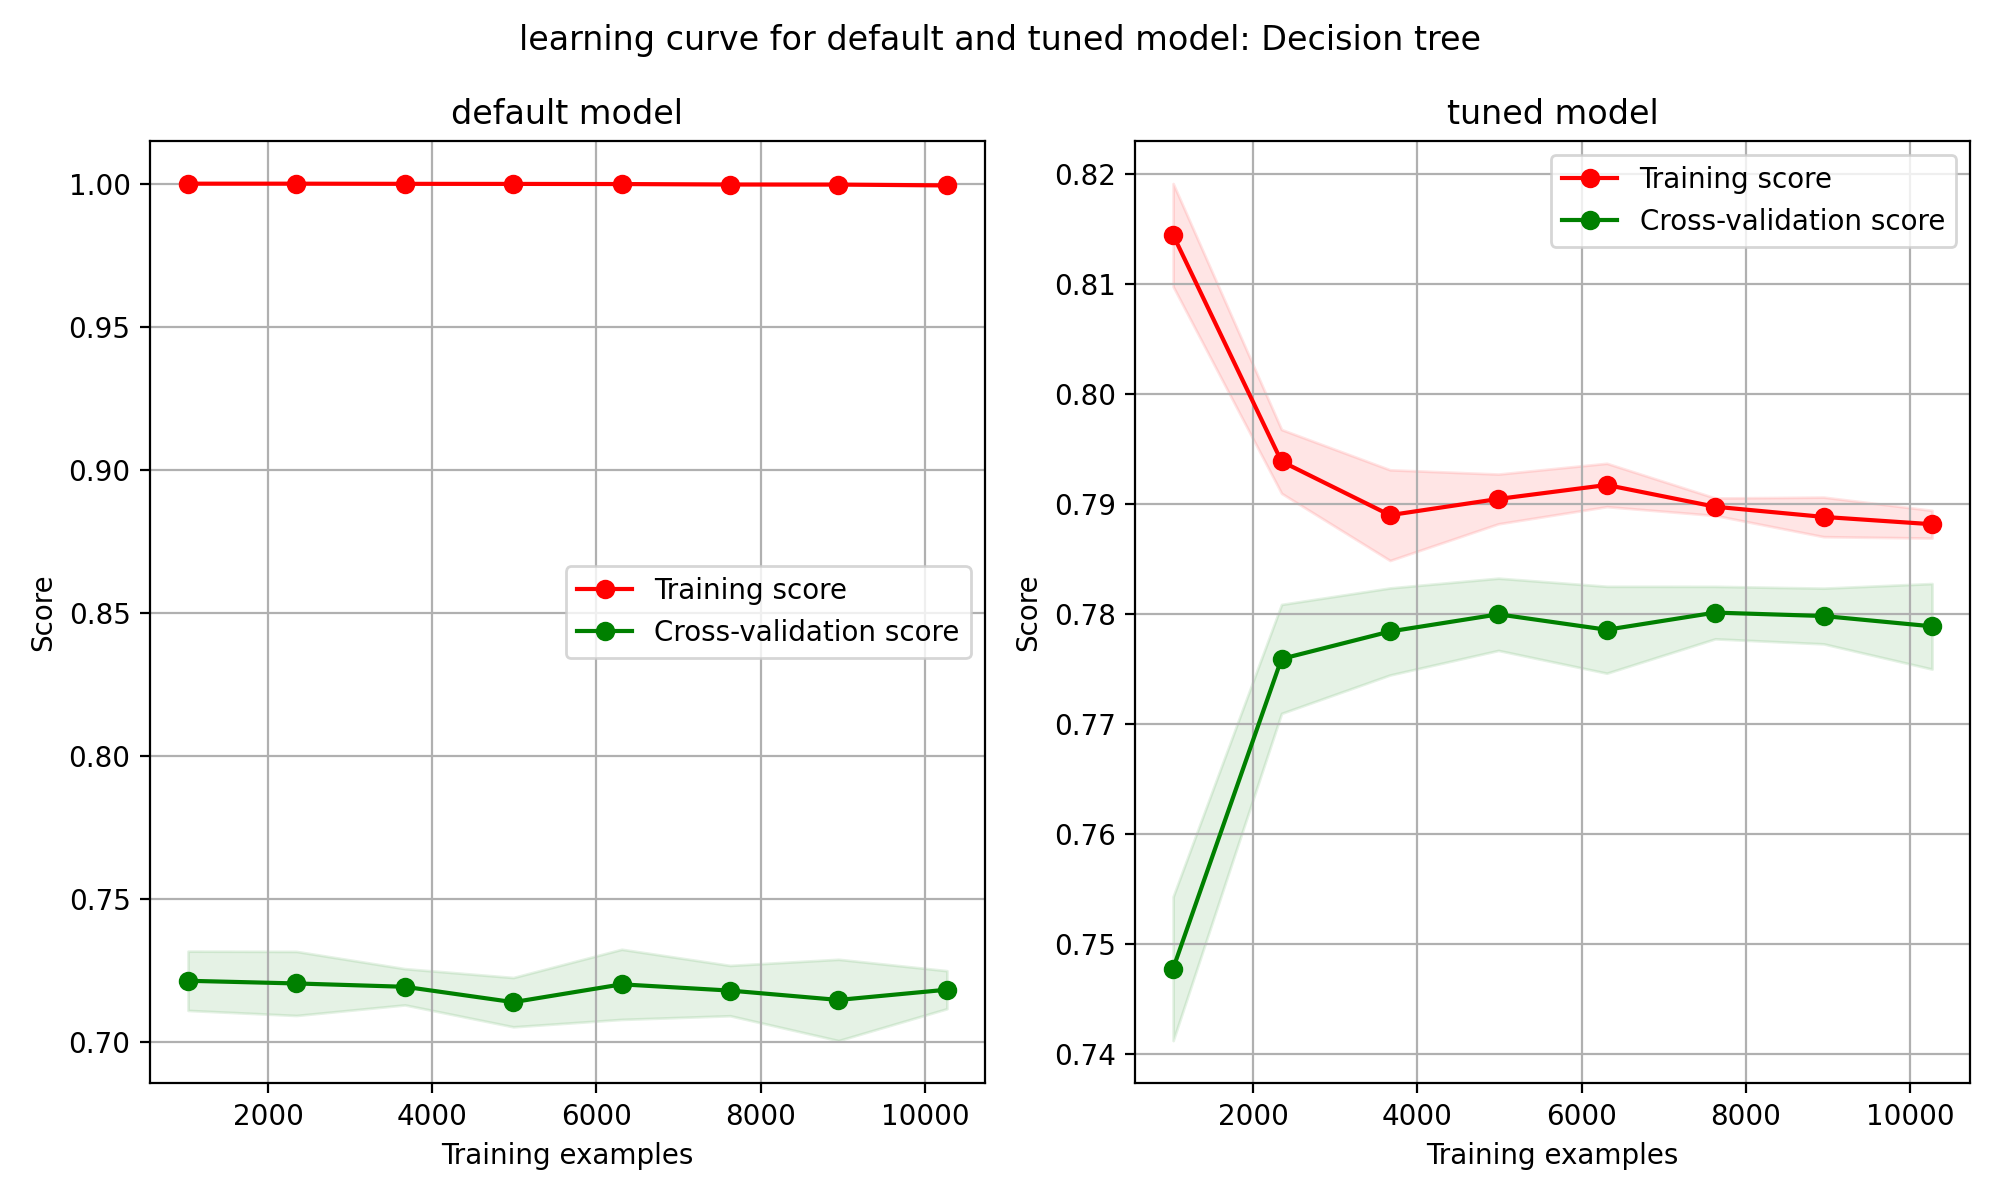

In [137]:
plot_two_learning_curves(pipe_dt_default,dt_best, "Decision tree", X_train, y_train, ylim=None, cv=None,
                        train_sizes=np.linspace(.1, 1.0, 8))

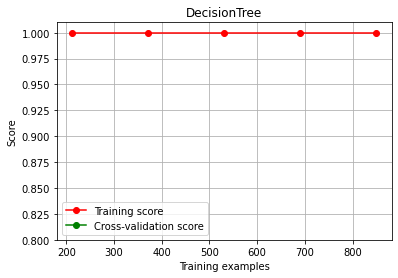

In [56]:
#少样本的情况情况下绘出学习曲线
plot_learning_curve(dt_clf, "DecisionTree",
                    x_train, y_train, ylim=(0.0, 1.01),
                    train_sizes=np.linspace(.05, 0.2, 5))

In [52]:
plot_learning_cuve(dt_clf, x_train, y_train)

TypeError: fit() got an unexpected keyword argument 'eval_metric'

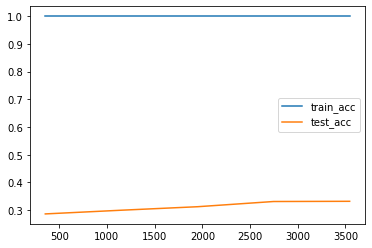

In [47]:
#将学习曲线给出的数据可视化
import matplotlib.pyplot as plt
plt.plot(train_size,train_acc.mean(axis=1),label='train_acc')
plt.plot(train_size,test_acc.mean(axis=1),label='test_acc')
plt.legend()
plt.show()

In [33]:
y_predict = dt_clf.predict(x_test)

In [34]:
y_predict

array([3, 0, 2, ..., 2, 1, 3], dtype=int32)

### confusion matrix

In [35]:
def plot_confusion_matrix(cm, class_names, model_name):

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion matrix')
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(i, j, "{:.2f}".format(cm[i, j]), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.savefig("./plots/{}_cm.png".format(model_name))

In [36]:
cm = sklearn.metrics.confusion_matrix(y_test,y_predict)

[[0.46712018 0.10657596 0.2154195  0.14058957 0.07029478]
 [0.20138889 0.19444444 0.375      0.02777778 0.20138889]
 [0.29137529 0.0979021  0.42890443 0.08391608 0.0979021 ]
 [0.43150685 0.04109589 0.23287671 0.23287671 0.06164384]
 [0.23668639 0.17751479 0.37278107 0.01775148 0.19526627]]


FileNotFoundError: [Errno 2] No such file or directory: './plots/dt_cm.png'

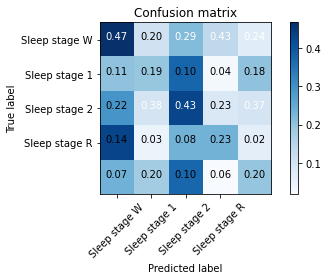

In [37]:
plot_confusion_matrix(cm,['Sleep stage W', 'Sleep stage 1', 'Sleep stage 2', 'Sleep stage R'],'dt')

In [21]:
y_predict

array([1, 3, 1, 0, 1, 3, 1, 0, 2, 0, 2, 0, 1, 0, 2, 4, 0, 0, 4, 4, 1, 0,
       3, 1, 3, 3, 0, 1, 1, 2, 1, 0, 4, 2, 0, 2, 3, 0, 3, 0, 4, 2, 3, 3,
       2, 2, 1, 2, 4, 3, 1, 3, 2, 3, 4, 0, 2, 0, 0, 1, 0, 4, 2, 2, 4, 4,
       3, 1, 2, 3, 2, 3, 2, 0, 0, 0, 1, 0, 0, 4, 3, 2, 1, 4, 4, 0, 0, 0,
       0, 3, 4, 4, 0, 2, 0, 1, 3, 4, 2, 3, 3, 3, 0, 2, 0, 4, 0, 1, 0, 4,
       4, 0, 0, 0, 4, 4, 3, 2, 0, 4, 1, 4, 2, 4, 0, 3, 2, 0, 0, 0, 2, 3,
       0, 2, 2, 0, 0, 2, 2, 0, 2, 0, 3, 2, 1, 1, 0, 0, 3, 0, 0, 1, 0, 2,
       0, 4, 2, 0, 2, 4, 0, 2, 0, 2, 2, 3, 4, 2, 0, 3, 0, 4, 4, 0, 1, 0,
       0, 0, 2, 0, 0, 0, 1, 2, 2, 4, 2, 4, 3, 3, 0, 2, 2, 0, 3, 0, 0, 3,
       2, 2, 3, 3, 0, 1, 0, 2, 0, 4, 0, 0, 0, 0, 1, 0, 3, 1, 2, 0, 4, 0,
       3, 2, 0, 1, 2, 3, 2, 2, 0, 0, 2, 0, 2, 4, 2, 0, 0, 1, 1, 4, 2, 3,
       2, 1, 2, 4, 1, 1, 0, 0, 2, 3, 2, 0, 0, 3, 0, 0, 0, 2, 3, 2, 1, 4,
       1, 1, 0, 2, 4, 2, 0, 3, 4, 3, 3, 0, 2, 0, 0, 0, 3, 1, 0, 2, 0, 3,
       3, 1, 0, 0, 3, 0, 1, 4, 3, 2, 2, 2, 4, 3, 2,

### plot AUC

In [25]:
from sklearn.metrics import roc_curve, auc

In [26]:
def convert_to_onehot(array):
    n_values = np.max(array) + 1
    return np.eye(n_values)[array]

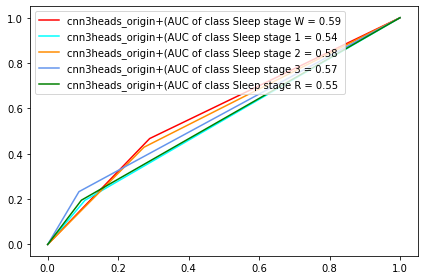

In [38]:
classes_to_plot=[0,1,2,3,4]
y_tests_oh = convert_to_onehot(y_test)
y_predict_oh = convert_to_onehot(y_predict)
# y_preds_oh = convert_to_onehot(y_pred1)

colors = ['red', 'aqua', 'darkorange', 'cornflowerblue', 'green', 'deeppink']
labels = ['Sleep stage W', 'Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage R']
plt.figure()
for c in classes_to_plot:
    fpr, tpr, _ = roc_curve(y_tests_oh[:, c], y_predict_oh[:, c])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"cnn3heads_origin+(AUC of class {labels[c]} = {roc_auc:0.2f}", color=colors[c])
# plt.legend(loc="lower right")
plt.legend()
plt.tight_layout()
plt.show()
# plt.savefig()

In [36]:
import numpy as np
data_path = "/Users/hoyu/hong/omscs/cs7641/cs7641-sl/data/processed/eeg_fpz_cz/SC4001E0.npz"
data = np.load(data_path)

In [55]:
file_1 = '/Users/hoyu/hong/omscs/cs7641/cs7641-sl/data/processed/eeg_fpz_cz/SC4001E0.npz'
file_2 = '/Users/hoyu/hong/omscs/cs7641/cs7641-sl/data/processed/eeg_fpz_cz/SC4002E0.npz'

In [56]:
file_list = [file_1, file_2]


In [68]:
from sklearn.utils import Bunch
dataset = Bunch()
data_all = [np.load(fname) for fname in file_list]
x_all = [np.squeeze(data['x']) for data in data_all]
y_all = [data['y'] for data in data_all]

In [69]:
x_all.shape

AttributeError: 'list' object has no attribute 'shape'

In [67]:
np.squeeze(x_all[0]).shape
# x_all[0].shape

(841, 3000)

In [70]:
dataset.data = np.concatenate(x_all)
dataset.target = np.concatenate(y_all)

In [74]:
feature_names = [f'time_{t}' for t in range(dataset.data.shape[1])]

In [76]:
feature_names[-3:]

['time_2997', 'time_2998', 'time_2999']

In [71]:
dataset.data.shape

(1968, 3000)

In [72]:
dataset.target.shape

(1968,)

In [44]:
len(data['x'][0])


3000

In [46]:
with np.load(data_path) as d:
    print(len(d['x']))

841


In [49]:
x = np.array([])


In [54]:
data['x'].shape

(841, 3000, 1)

In [50]:
x = np.concatenate(x,data['x'])

TypeError: only integer scalar arrays can be converted to a scalar index

# Problem 2: HR Analytics



In [59]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
# from xgboost import XGBClassifier
from sklearn import model_selection
from sklearn.utils import class_weight
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [73]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_classif
from sklearn.model_selection import KFold
from sklearn.feature_selection import SelectFromModel
from sklearn.svm import LinearSVC

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict

from sklearn.preprocessing import normalize
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.decomposition import PCA

from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import CategoricalNB
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler

In [75]:
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.model_selection import GridSearchCV

In [76]:
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

In [61]:
import pandas as pd
import numpy as np

In [64]:
hr_dataset = pd.read_csv('/Users/hoyu/hong/omscs/cs7641/cs7641-sl/data/HR/aug_train.csv')
hr_dataset.head(10)

enrollee_id      city  city_development_index gender  \
0         8949  city_103                   0.920   Male   
1        29725   city_40                   0.776   Male   
2        11561   city_21                   0.624    NaN   
3        33241  city_115                   0.789    NaN   
4          666  city_162                   0.767   Male   
5        21651  city_176                   0.764    NaN   
6        28806  city_160                   0.920   Male   
7          402   city_46                   0.762   Male   
8        27107  city_103                   0.920   Male   
9          699  city_103                   0.920    NaN   

       relevent_experience enrolled_university education_level  \
0  Has relevent experience       no_enrollment        Graduate   
1   No relevent experience       no_enrollment        Graduate   
2   No relevent experience    Full time course        Graduate   
3   No relevent experience                 NaN        Graduate   
4  Has relevent experience       no_enrollment         Masters   
5  Has relevent experience    Part time course        Graduate   
6  Has relevent experience       no_enrollment     High School   
7  Has relevent experience       no_enrollment        Graduate   
8  Has relevent experience       no_enrollment        Graduate   
9  Has relevent experience       no_enrollment        Graduate   

  major_discipline experience company_size    company_type last_new_job  \
0             STEM        >20          NaN             NaN            1   
1             STEM         15        50-99         Pvt Ltd           >4   
2             STEM          5          NaN             NaN        never   
3  Business Degree         <1          NaN         Pvt Ltd        never   
4             STEM        >20        50-99  Funded Startup            4   
5             STEM         11          NaN             NaN            1   
6              NaN          5        50-99  Funded Startup            1   
7             STEM         13          <10         Pvt Ltd           >4   
8             STEM          7        50-99         Pvt Ltd            1   
9             STEM         17       10000+         Pvt Ltd           >4   

   training_hours  target  
0              36     1.0  
1              47     0.0  
2              83     0.0  
3              52     1.0  
4               8     0.0  
5              24     1.0  
6              24     0.0  
7              18     1.0  
8              46     1.0  
9             123     0.0

In [65]:
hr_dataset.drop("enrollee_id", axis=1, inplace=True)

In [67]:
categorical = (hr_dataset.dtypes == "object")
categorical_list = list(categorical[categorical].index)

print("Categorical variables:")
print(categorical_list)

Categorical variables:
['city', 'gender', 'relevent_experience', 'enrolled_university', 'education_level', 'major_discipline', 'experience', 'company_size', 'company_type', 'last_new_job']


In [69]:
numerical_int64 = (hr_dataset.dtypes == "int64")
numerical_int64_list = list(numerical_int64[numerical_int64].index)

print("Categorical variables:")
print(numerical_int64_list)

Categorical variables:
['training_hours']


### One-Hot Encoding

In [71]:
cat_var =  ['city', 'gender', 'relevent_experience', 'enrolled_university', 'education_level', 
            'major_discipline', 'experience', 'company_size', 'company_type', 'last_new_job']

for i in range (0, len(cat_var)):
    print(f'Unique Values for {cat_var[i]}', hr_dataset[f'{cat_var[i]}'].unique())

Unique Values for city ['city_103' 'city_40' 'city_21' 'city_115' 'city_162' 'city_176'
 'city_160' 'city_46' 'city_61' 'city_114' 'city_13' 'city_159' 'city_102'
 'city_67' 'city_100' 'city_16' 'city_71' 'city_104' 'city_64' 'city_101'
 'city_83' 'city_105' 'city_73' 'city_75' 'city_41' 'city_11' 'city_93'
 'city_90' 'city_36' 'city_20' 'city_57' 'city_152' 'city_19' 'city_65'
 'city_74' 'city_173' 'city_136' 'city_98' 'city_97' 'city_50' 'city_138'
 'city_82' 'city_157' 'city_89' 'city_150' 'city_70' 'city_175' 'city_94'
 'city_28' 'city_59' 'city_165' 'city_145' 'city_142' 'city_26' 'city_12'
 'city_37' 'city_43' 'city_116' 'city_23' 'city_99' 'city_149' 'city_10'
 'city_45' 'city_80' 'city_128' 'city_158' 'city_123' 'city_7' 'city_72'
 'city_106' 'city_143' 'city_78' 'city_109' 'city_24' 'city_134' 'city_48'
 'city_144' 'city_91' 'city_146' 'city_133' 'city_126' 'city_118' 'city_9'
 'city_167' 'city_27' 'city_84' 'city_54' 'city_39' 'city_79' 'city_76'
 'city_77' 'city_81' 'city_13

In [74]:
onehotencoder = sklearn.preprocessing.OneHotEncoder()

In [77]:
one_hot = ['city', 'gender', 'relevent_experience', 'enrolled_university', 'education_level', 
            'major_discipline', 'experience', 'company_size', 'company_type', 'last_new_job']

for i in range(0, len(one_hot)):
    hr_dataset[f'{one_hot[i]}'] = pd.Categorical(hr_dataset[f'{one_hot[i]}'])
    dummies = pd.get_dummies(hr_dataset[f'{one_hot[i]}'], prefix = f'{one_hot[i]}_encoded')
    hr_dataset.drop([f'{one_hot[i]}'], axis=1, inplace=True)
    hr_dataset = pd.concat([hr_dataset, dummies], axis=1)

In [78]:
hr_dataset

city_development_index  training_hours  target  city_encoded_city_1  \
0                       0.920              36     1.0                    0   
1                       0.776              47     0.0                    0   
2                       0.624              83     0.0                    0   
3                       0.789              52     1.0                    0   
4                       0.767               8     0.0                    0   
...                       ...             ...     ...                  ...   
19153                   0.878              42     1.0                    0   
19154                   0.920              52     1.0                    0   
19155                   0.920              44     0.0                    0   
19156                   0.802              97     0.0                    0   
19157                   0.855             127     0.0                    0   

       city_encoded_city_10  city_encoded_city_100  city_encoded_city_101  \
0                         0                      0                      0   
1                         0                      0                      0   
2                         0                      0                      0   
3                         0                      0                      0   
4                         0                      0                      0   
...                     ...                    ...                    ...   
19153                     0                      0                      0   
19154                     0                      0                      0   
19155                     0                      0                      0   
19156                     0                      0                      0   
19157                     0                      0                      0   

       city_encoded_city_102  city_encoded_city_103  city_encoded_city_104  \
0                          0                      1                      0   
1                          0                      0                      0   
2                          0                      0                      0   
3                          0                      0                      0   
4                          0                      0                      0   
...                      ...                    ...                    ...   
19153                      0                      0                      0   
19154                      0                      1                      0   
19155                      0                      1                      0   
19156                      0                      0                      0   
19157                      0                      0                      0   

       ...  company_type_encoded_NGO  company_type_encoded_Other  \
0      ...                         0                           0   
1      ...                         0                           0   
2      ...                         0                           0   
3      ...                         0                           0   
4      ...                         0                           0   
...    ...                       ...                         ...   
19153  ...                         0                           0   
19154  ...                         0                           0   
19155  ...                         0                           0   
19156  ...                         0                           0   
19157  ...                         0                           0   

       company_type_encoded_Public Sector  company_type_encoded_Pvt Ltd  \
0                                       0                             0   
1                                       0                             1   
2                                       0                             0   
3                                       0                             1   
4               

### train test split

In [138]:
X = hr_dataset.drop(["target"],axis =1)
y = hr_dataset["target"]

In [140]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) 
# X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

print(f'Total # of sample in whole dataset: {len(X)}')
print(f'Total # of sample in train dataset: {len(X_train)}')
print(f'Total # of sample in test dataset: {len(X_test)}')

Total # of sample in whole dataset: 19158
Total # of sample in train dataset: 15326
Total # of sample in test dataset: 3832


## Pipelines

In [153]:
pipeline_DecisionTree = Pipeline([("scaler",StandardScaler()),
                     ("pipeline_DecisionTree",DecisionTreeClassifier())])

# neural networks (TODO)
mlp_clf = sklearn.neural_network.MLPClassifier(hidden_layer_sizes=(32,64,32))
pipeline_MLP = Pipeline([("scaler",StandardScaler()), 
                         ("pipeline_MLP",mlp_clf)])
# Boosting
pipeline_GBC = Pipeline([("scaler",StandardScaler()), (
                        "pipeline_GBC",GradientBoostingClassifier())])

# SVM linear
pipeline_SVM = Pipeline([("scaler",StandardScaler()), 
                         ("pipeline_SVM_Linear",sklearn.svm.SVC())
                        ])
svm_linear = sklearn.svm.SVC(C=1.0, 
                          kernel='linear', 
                          shrinking=True, 
                          probability=False, 
                          tol=0.001, 
                          cache_size=200, 
                          max_iter=- 1, 
                          decision_function_shape='ovr', 
                          break_ties=False, 
                          random_state=None)

svm_rbf = sklearn.svm.SVC(C=1.0, 
                          kernel='rbf', 
                          gamma='scale', 
                          shrinking=True, 
                          probability=False, 
                          tol=0.001, 
                          cache_size=200, 
                          max_iter=- 1, 
                          decision_function_shape='ovr', 
                          break_ties=False, 
                          random_state=None)
pipeline_SVM_Linear = Pipeline([("scaler",StandardScaler()), 
                         ("pipeline_SVM_Linear",svm_linear)
                        ])
# SVM rbf
pipeline_SVM_RBF = Pipeline([("scaler",StandardScaler()), 
                         ("pipeline_SVM_RBF",svm_rbf)
                        ])

# KNN
pipeline_KNN = Pipeline([("scaler",StandardScaler()),
                     ("pipeline_KNN",KNeighborsClassifier())])

### DT

Pipeline(steps=[('scaler', StandardScaler()),
                ('pipeline_DecisionTree', DecisionTreeClassifier())])

<module 'matplotlib.pyplot' from '/Users/hoyu/hong/omscs/cs7641/venv/lib/python3.8/site-packages/matplotlib/pyplot.py'>

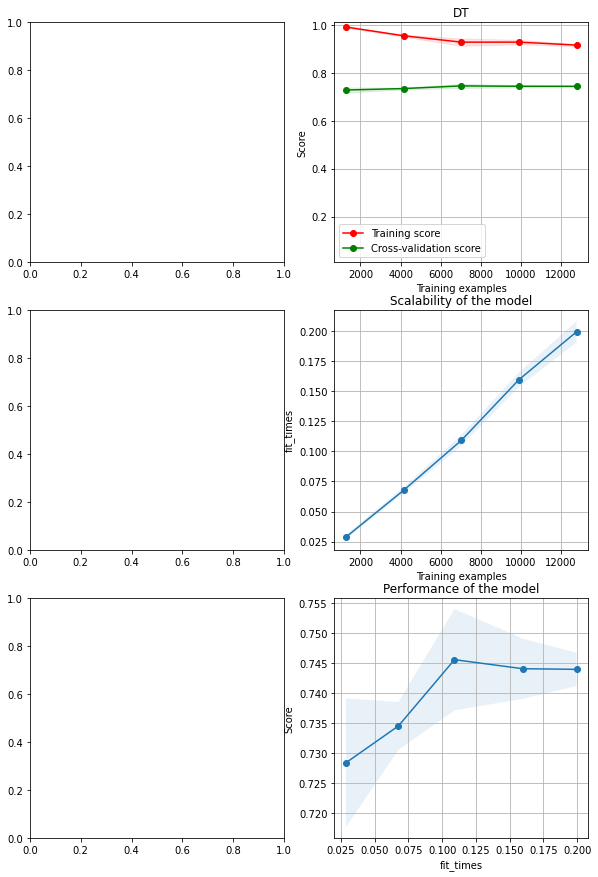

In [86]:
title = "DT"
estimator = pipeline_DecisionTree
fig, axes = plt.subplots(3, 2, figsize=(10, 15))
plot_learning_curve(estimator, title, X, y, axes=axes[:, 1], ylim=(0.01, 1.01),
                    cv=3, n_jobs=4)

In [88]:
pipeline_GaussianNB = Pipeline([("scaler",StandardScaler()),
                     ("pipeline_GaussianNB",GaussianNB())])

pipeline_BernoulliNB = Pipeline([("scaler",StandardScaler()),
                     ("pipeline_BernoulliNB",BernoulliNB())])

pipeline_LogisticRegression = Pipeline([("scaler",StandardScaler()),
                     ("pipeline_LogisticRegression",LogisticRegression())])

pipeline_RandomForest = Pipeline([("scaler",StandardScaler()),
                     ("pipeline_RandomForest",RandomForestClassifier())])

pipeline_DecisionTree = Pipeline([("scaler",StandardScaler()),
                     ("pipeline_DecisionTree",DecisionTreeClassifier())])

pipeline_KNN = Pipeline([("scaler",StandardScaler()),
                     ("pipeline_KNN",KNeighborsClassifier())])

pipeline_GBC = Pipeline([("scaler",StandardScaler()), (
                        "pipeline_GBC",GradientBoostingClassifier())])

pipeline_SGD = Pipeline([("scaler",StandardScaler()), 
                        ("pipeline_SGD",SGDClassifier(max_iter=5000, random_state=0))])

# pipeline_LGBM = Pipeline([("scaler",StandardScaler()), 
#                         ("pipeline_NN",lightgbm.LGBMClassifier())])

pipelines = [pipeline_GaussianNB, 
             pipeline_BernoulliNB, 
             pipeline_LogisticRegression, 
             pipeline_RandomForest, 
             pipeline_DecisionTree, 
             pipeline_KNN, 
             pipeline_GBC, 
             pipeline_SGD, 
#              pipeline_LGBM
            ]

pipe_dict = {0: "GaussianNB", 1: "BernoulliNB", 2: "LogisticRegression",3: "RandomForestClassifier", 4: "DecisionTreeClassifier",
            5: "KNeighborsClassifier", 6: "GradientBoostingClassifier", 
             7:"Stochastic Gradient Descent", 
#              8: "LGBM"
            }

modelNames = ["GaussianNB", 'BernoulliNB','LogisticRegression','RandomForestClassifier',
             'DecisionTreeClassifier', 'KNeighborsClassifier','GradientBoostingClassifier',
             'Stochastic Gradient Descent', 
#               'LGBM'
             ]



### GridSearch for DT

In [146]:
def plot_validation_curve(cv_results,param_range, param_name):
    plt.figure()
    mean_test_score = cv_results['mean_test_score']
    std_test_score = cv_results['std_test_score']
#     param_range = [5, 10, 20, 30, 50]
    plt.title("Validation Curve with Decision Tree")
    plt.xlabel(param_name)
    plt.ylabel("Score")
    plt.ylim(0.0, 1.1)
    lw = 2

    plt.plot(param_range, mean_test_score, label="Test score",
                 color="darkorange", lw=lw)
    plt.fill_between(param_range, mean_test_score - std_test_score,
                     mean_test_score + std_test_score, alpha=0.2,
                     color="darkorange", lw=lw)
    # plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
    #              color="navy", lw=lw)
    # plt.fill_between(param_range, test_scores_mean - test_scores_std,
    #                  test_scores_mean + test_scores_std, alpha=0.2,
    #                  color="navy", lw=lw)
    plt.legend(loc="best")
    plt.show()


### MLP

/Users/hoyu/hong/omscs/cs7641/venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


<IPython.core.display.Javascript object>


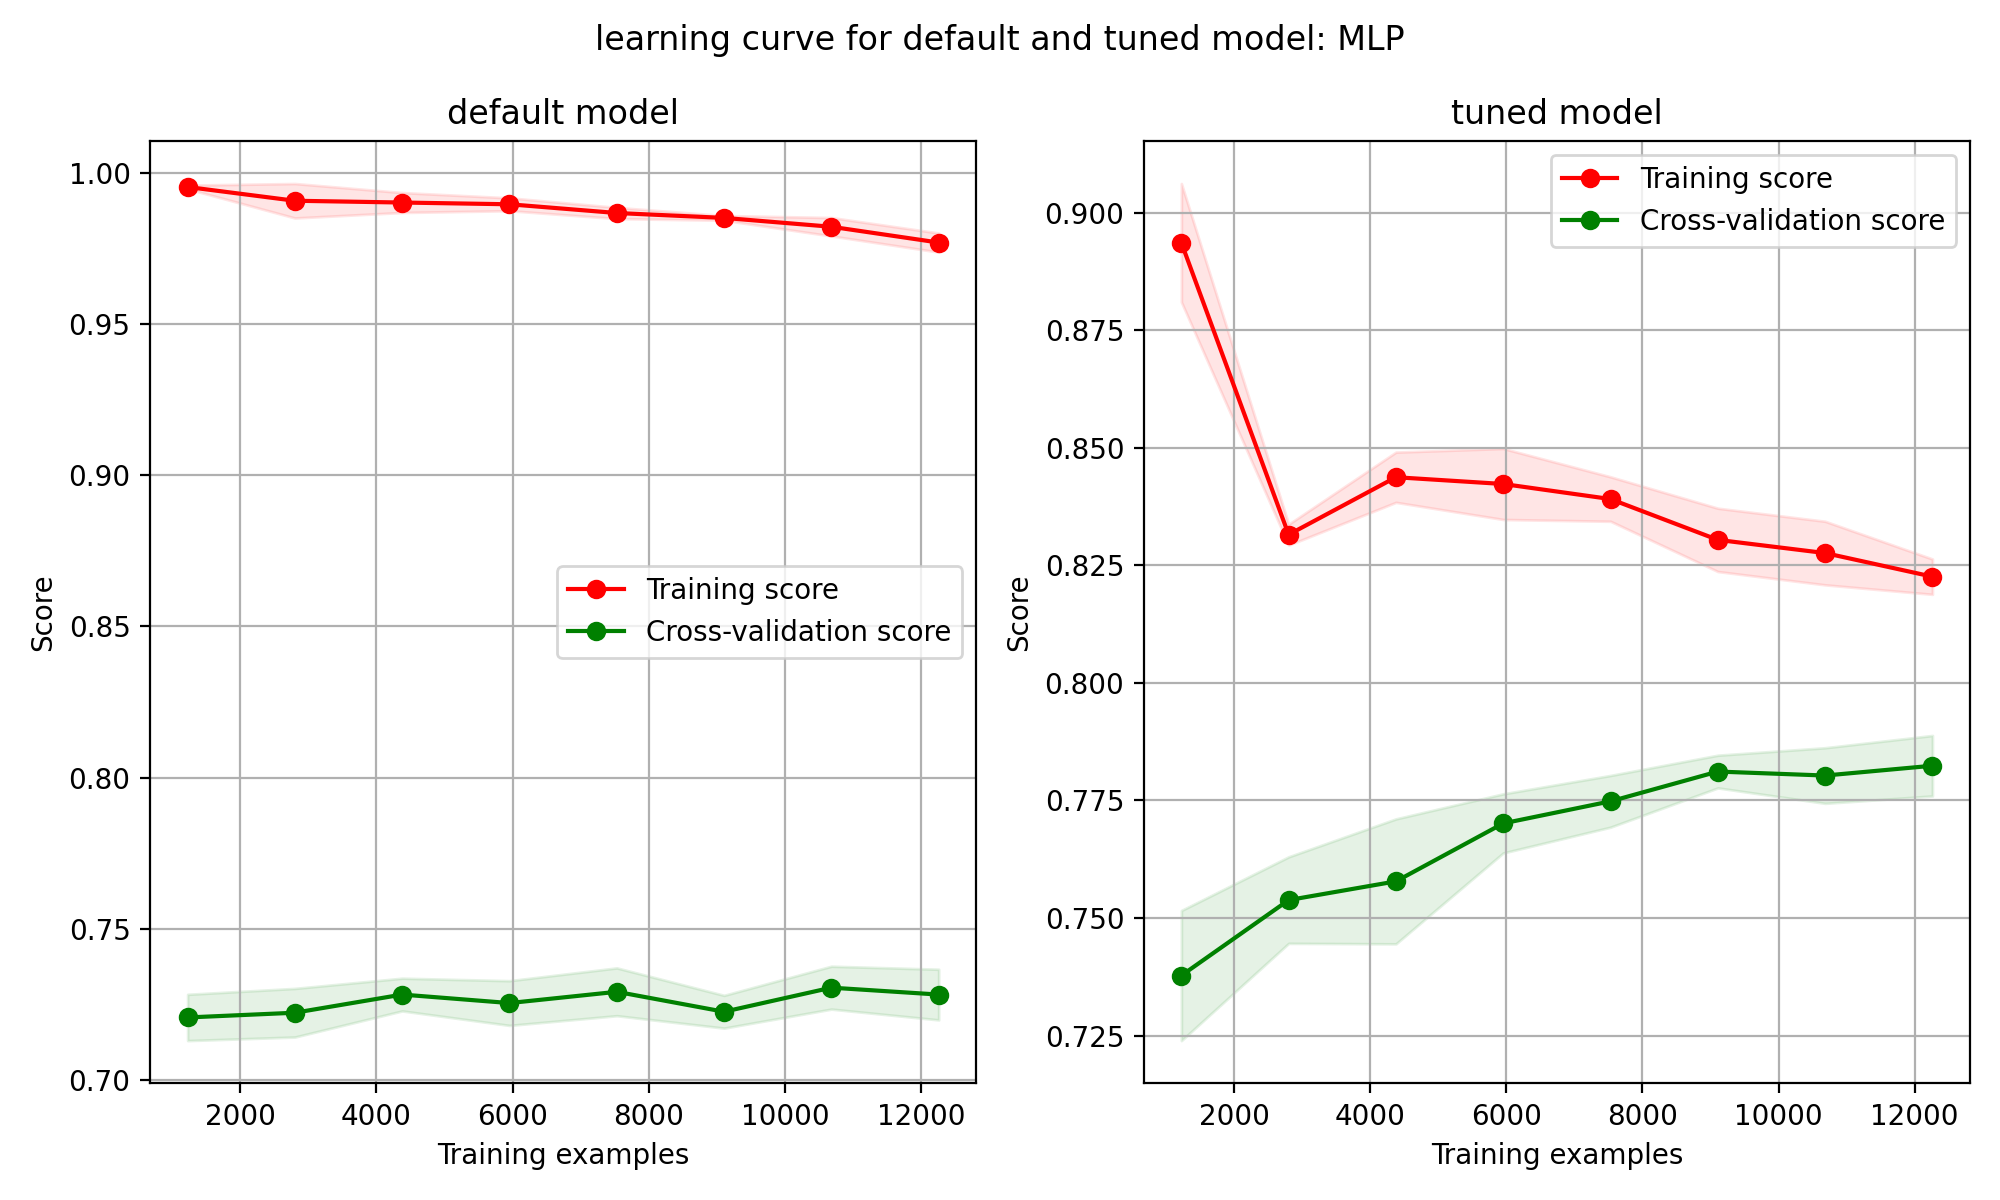

/Users/hoyu/hong/omscs/cs7641/venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/hoyu/hong/omscs/cs7641/venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/hoyu/hong/omscs/cs7641/venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/hoyu/hong/omscs/cs7641/venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warning

/Users/hoyu/hong/omscs/cs7641/venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/hoyu/hong/omscs/cs7641/venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/hoyu/hong/omscs/cs7641/venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/hoyu/hong/omscs/cs7641/venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warning

<IPython.core.display.Javascript object>


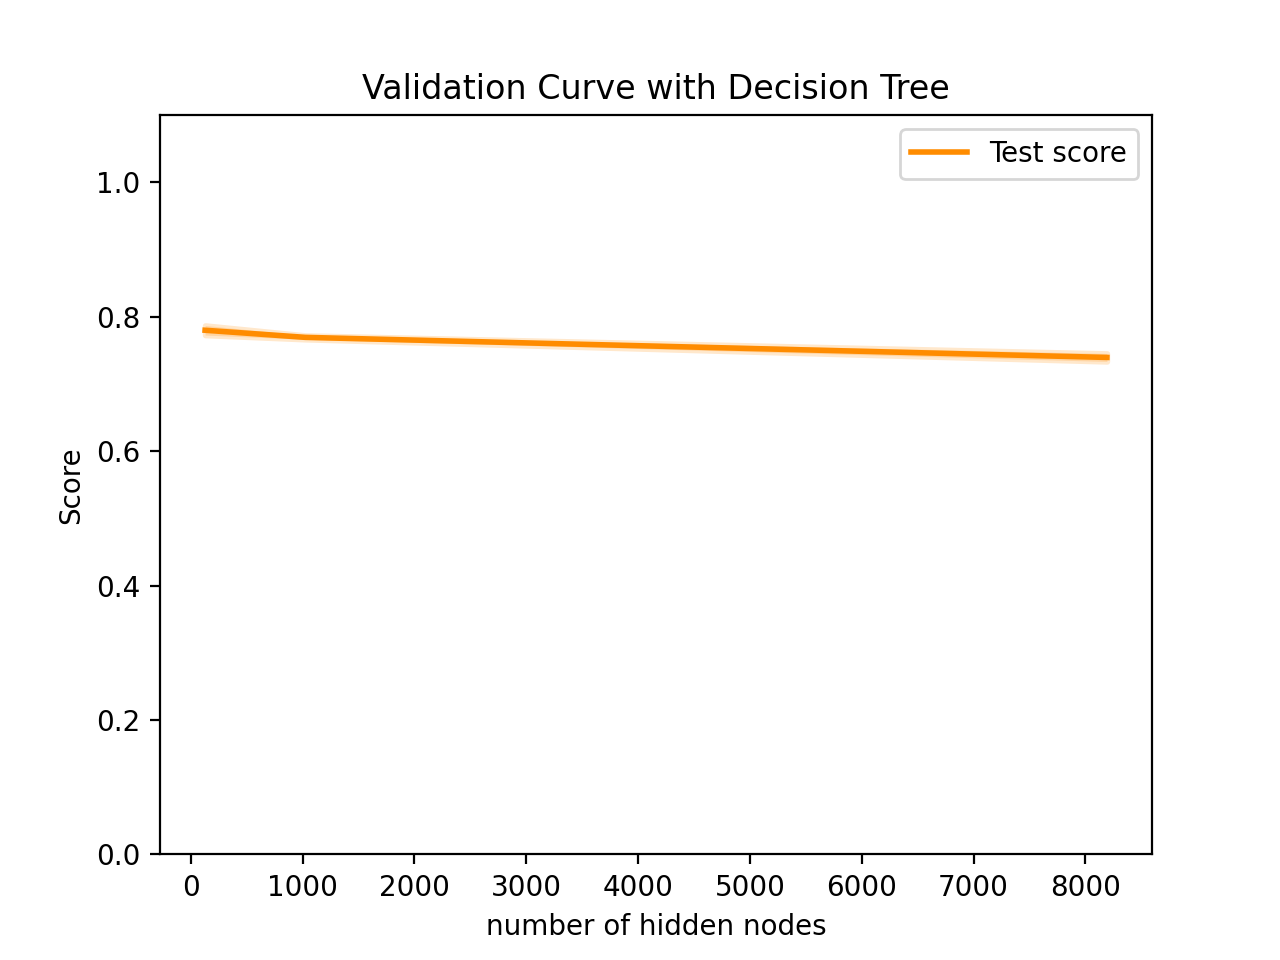

In [148]:
default_pipeline = pipeline_MLP
# Parameters of pipelines can be set using ‘__’ separated parameter names:
param_grid = {
    'pipeline_MLP__hidden_layer_sizes': [(4,8,4),(8,16,8),(16,32,16)],
}


search = GridSearchCV(default_pipeline, param_grid, n_jobs=-1)
search.fit(X_train, y_train)
best_pipeline = search.best_estimator_
plot_two_learning_curves(default_pipeline,best_pipeline, "MLP", X_train, y_train, ylim=None, cv=None,
                        train_sizes=np.linspace(.1, 1.0, 8))
cv_results = search.cv_results_
param_range = [4**3*2,8**3*2,16**3*2]
param_name = "number of hidden nodes"
plot_validation_curve(cv_results,param_range, param_name)


### Boosting

<IPython.core.display.Javascript object>


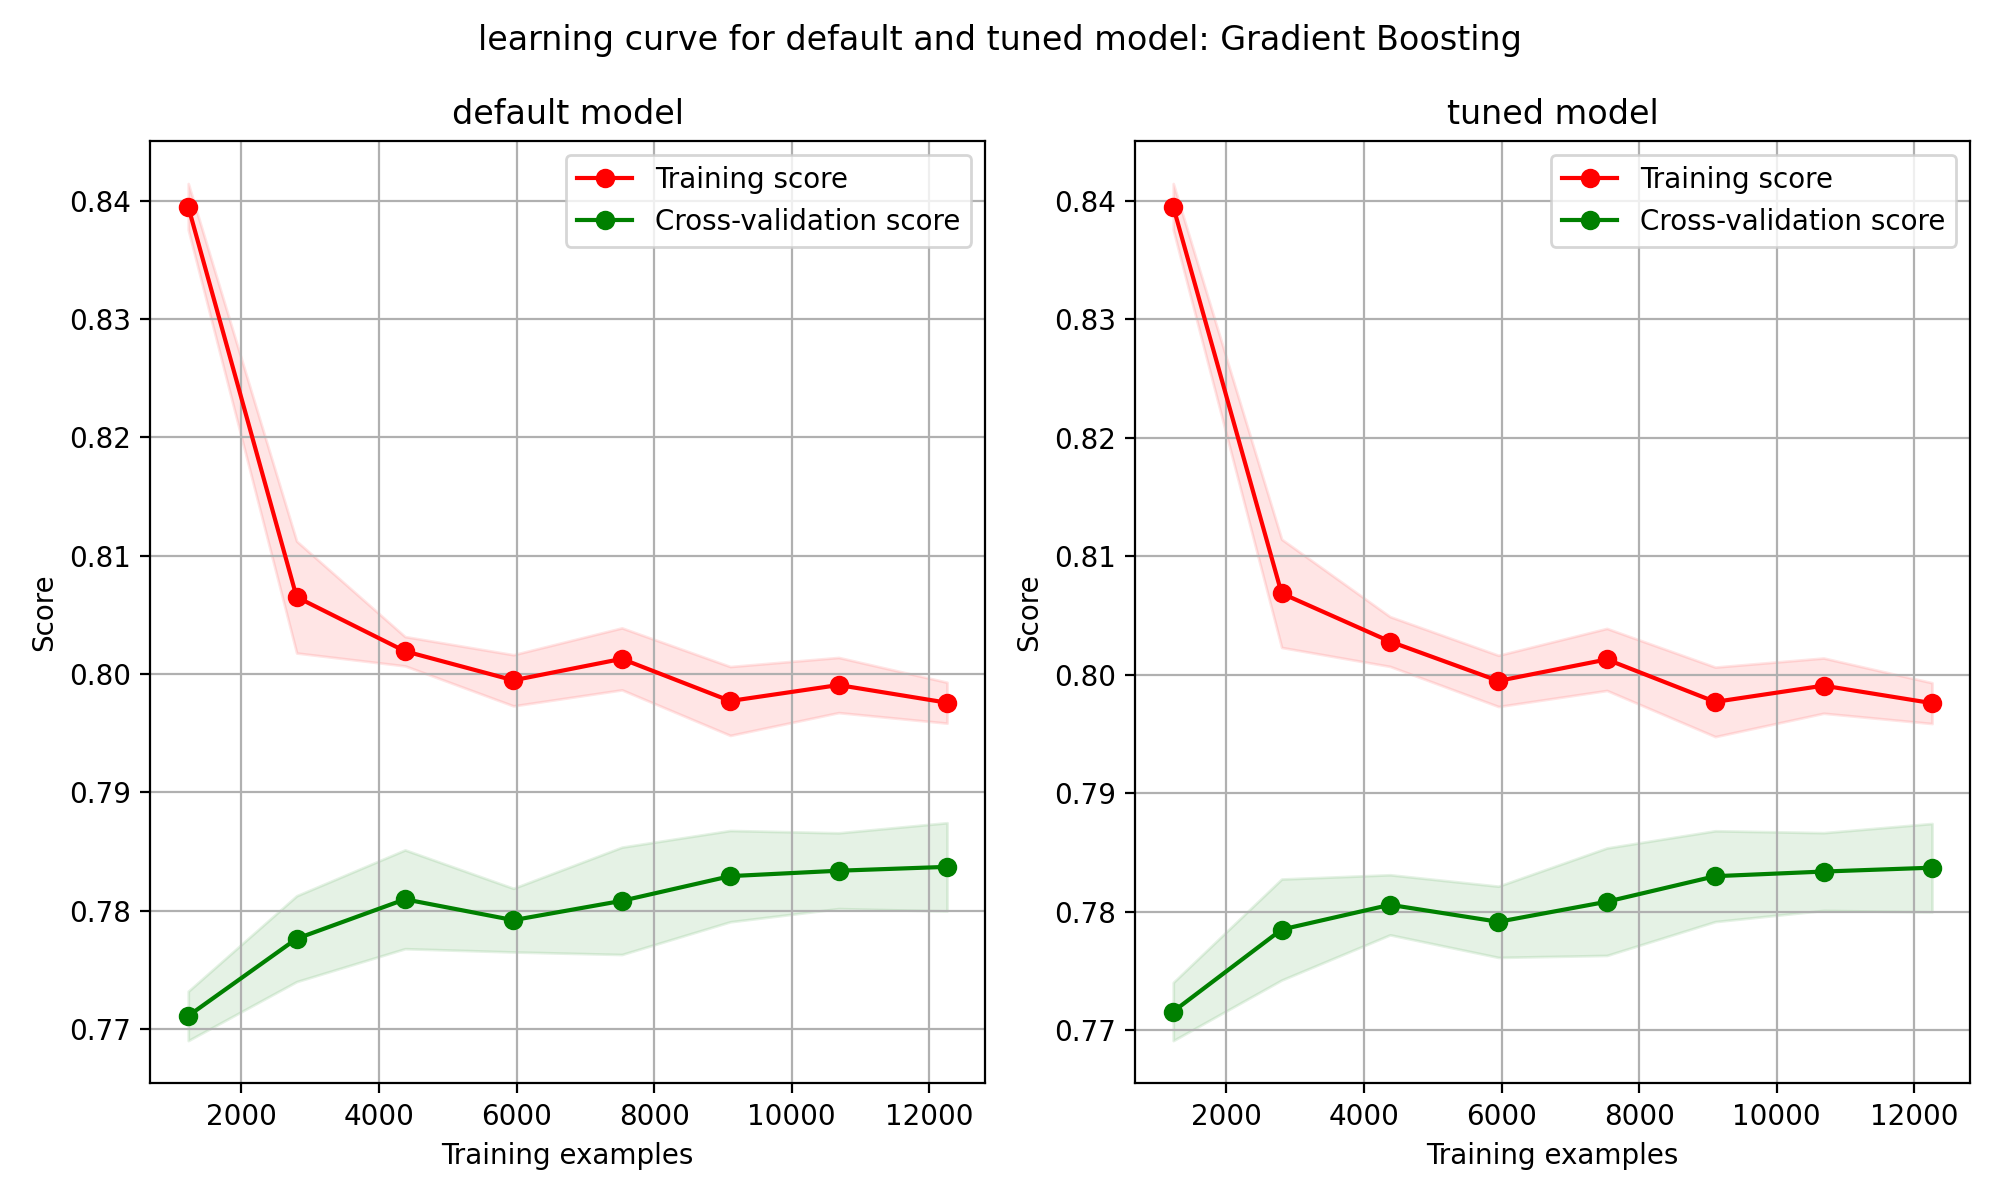

<IPython.core.display.Javascript object>


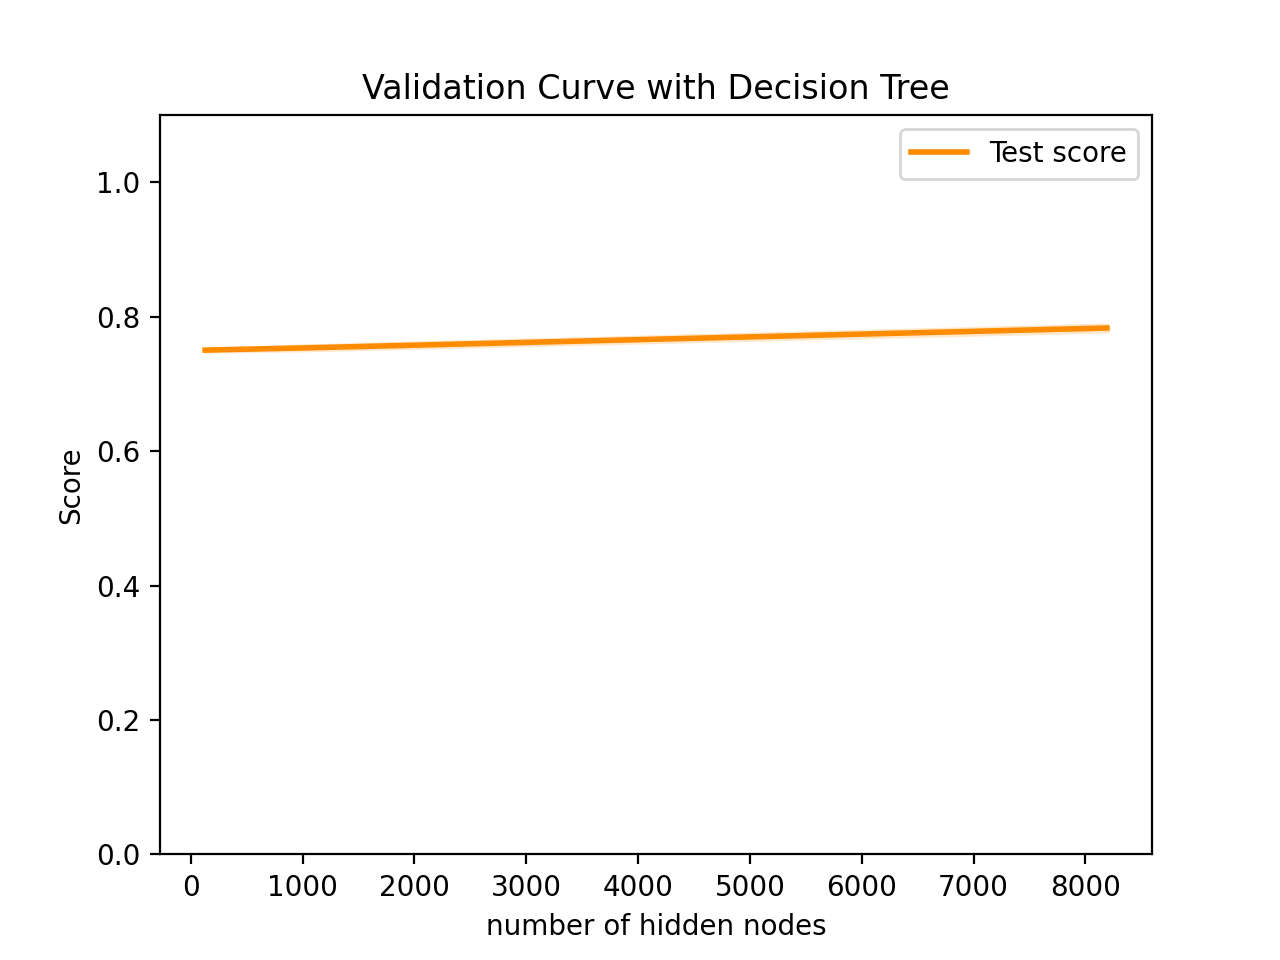

In [149]:
default_pipeline = pipeline_GBC
model_name = "Gradient Boosting"
param_name = "learning rate"
param_range = [0.001,0.01,0.1]
# Parameters of pipelines can be set using ‘__’ separated parameter names:
param_grid = {
    'pipeline_GBC__learning_rate': param_range,
}

search = GridSearchCV(default_pipeline, param_grid, n_jobs=-1)
search.fit(X_train, y_train)
best_pipeline = search.best_estimator_
plot_two_learning_curves(default_pipeline,best_pipeline, model_name, X_train, y_train, ylim=None, cv=None,
                        train_sizes=np.linspace(.1, 1.0, 8))
cv_results = search.cv_results_

plot_validation_curve(cv_results,param_range, param_name)

### SVM

In [150]:
default_pipeline = pipeline_SVM
model_name = "SVM"
param_name = "kernel"
param_range = ['linear','rbf']
param_range_number = [1,2]
# Parameters of pipelines can be set using ‘__’ separated parameter names:
param_grid = {
    'pipeline_SVM__kernel': param_range,
}

search = GridSearchCV(default_pipeline, param_grid, n_jobs=-1)
search.fit(X_train, y_train)
best_pipeline = search.best_estimator_
plot_two_learning_curves(default_pipeline,best_pipeline, model_name, X_train, y_train, ylim=None, cv=None,
                        train_sizes=np.linspace(.1, 1.0, 8))
cv_results = search.cv_results_

plot_validation_curve(cv_results,param_range_number, param_name)

NameError: name 'pipeline_SVM' is not defined

### KNN


<IPython.core.display.Javascript object>


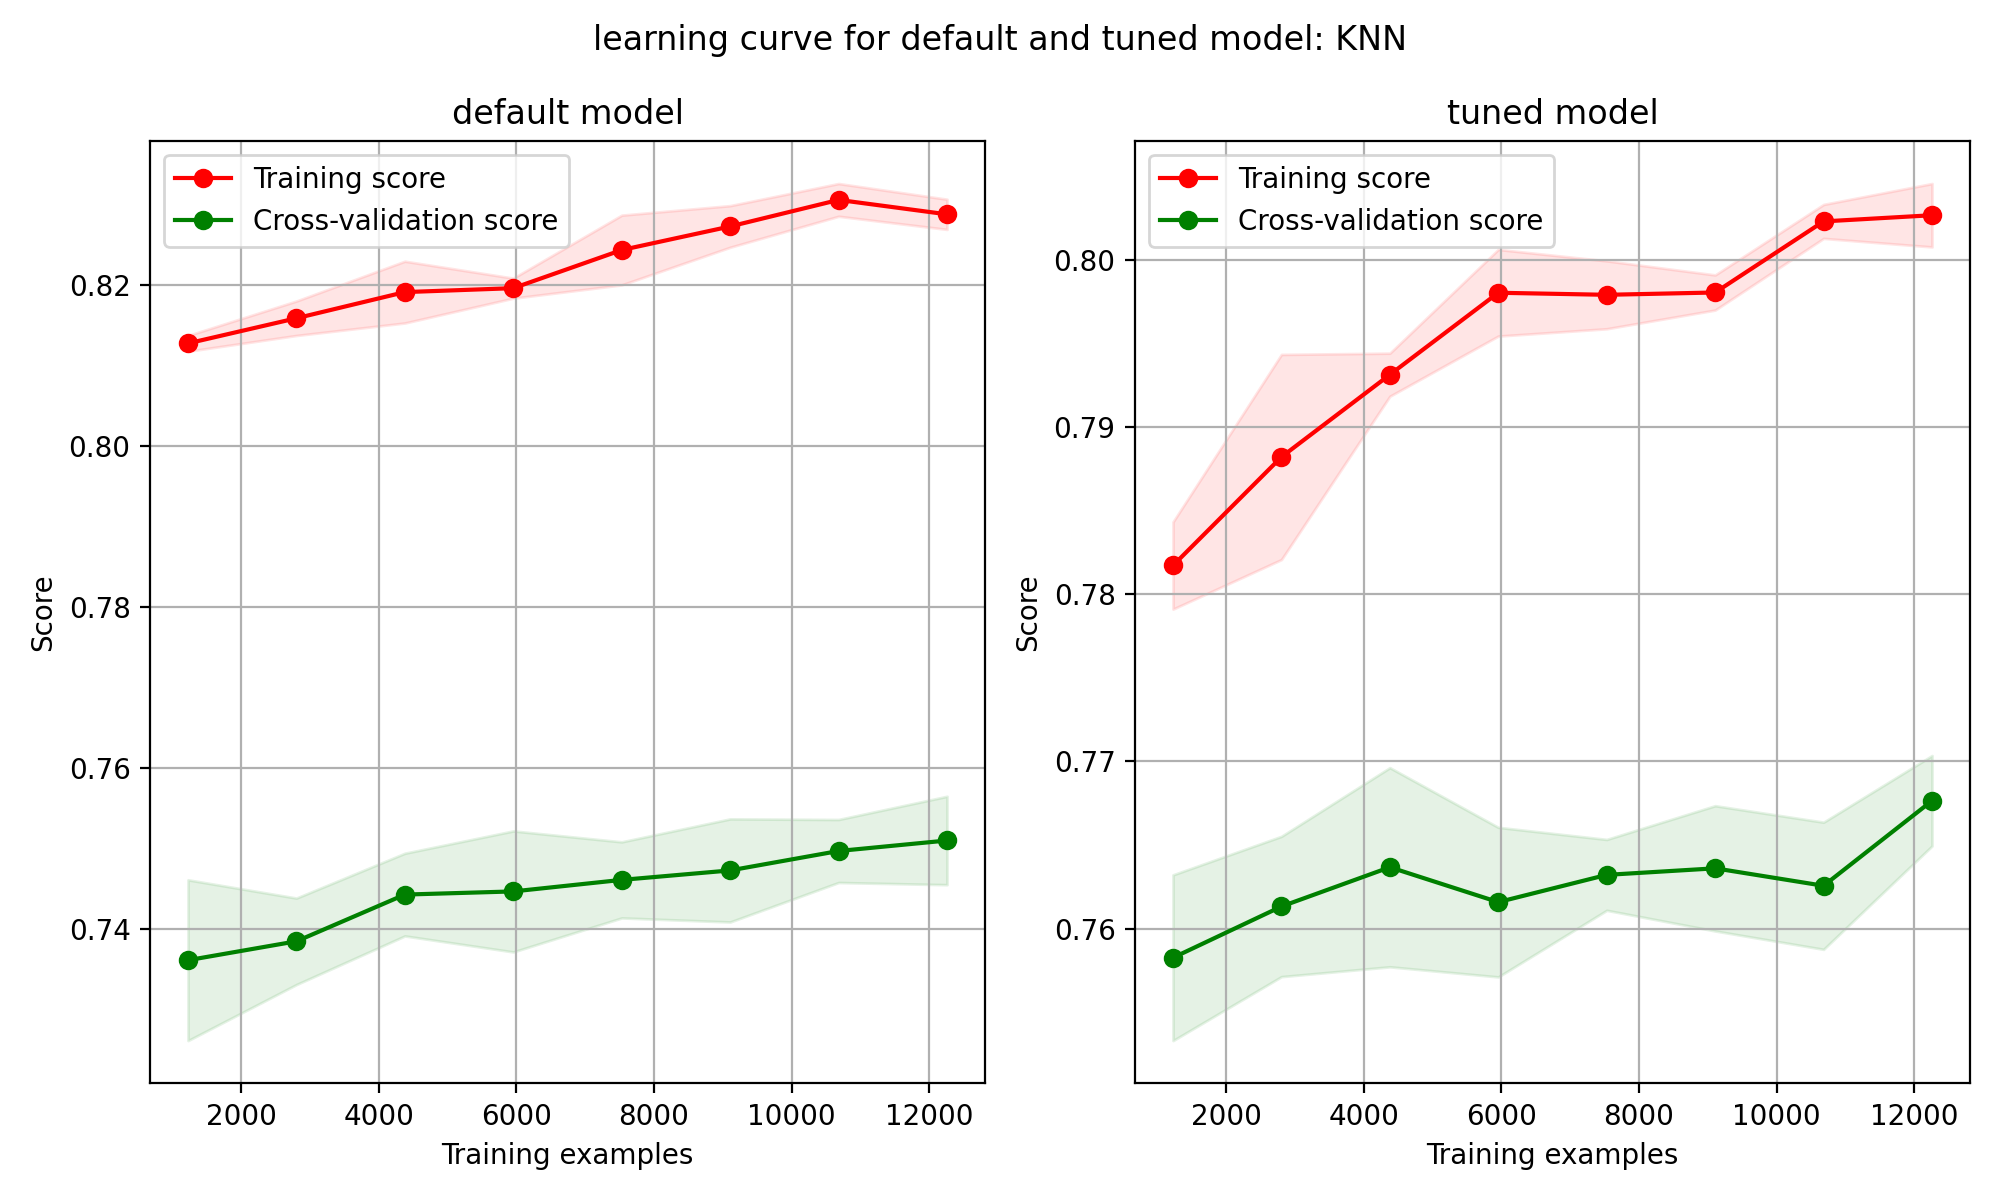

<IPython.core.display.Javascript object>


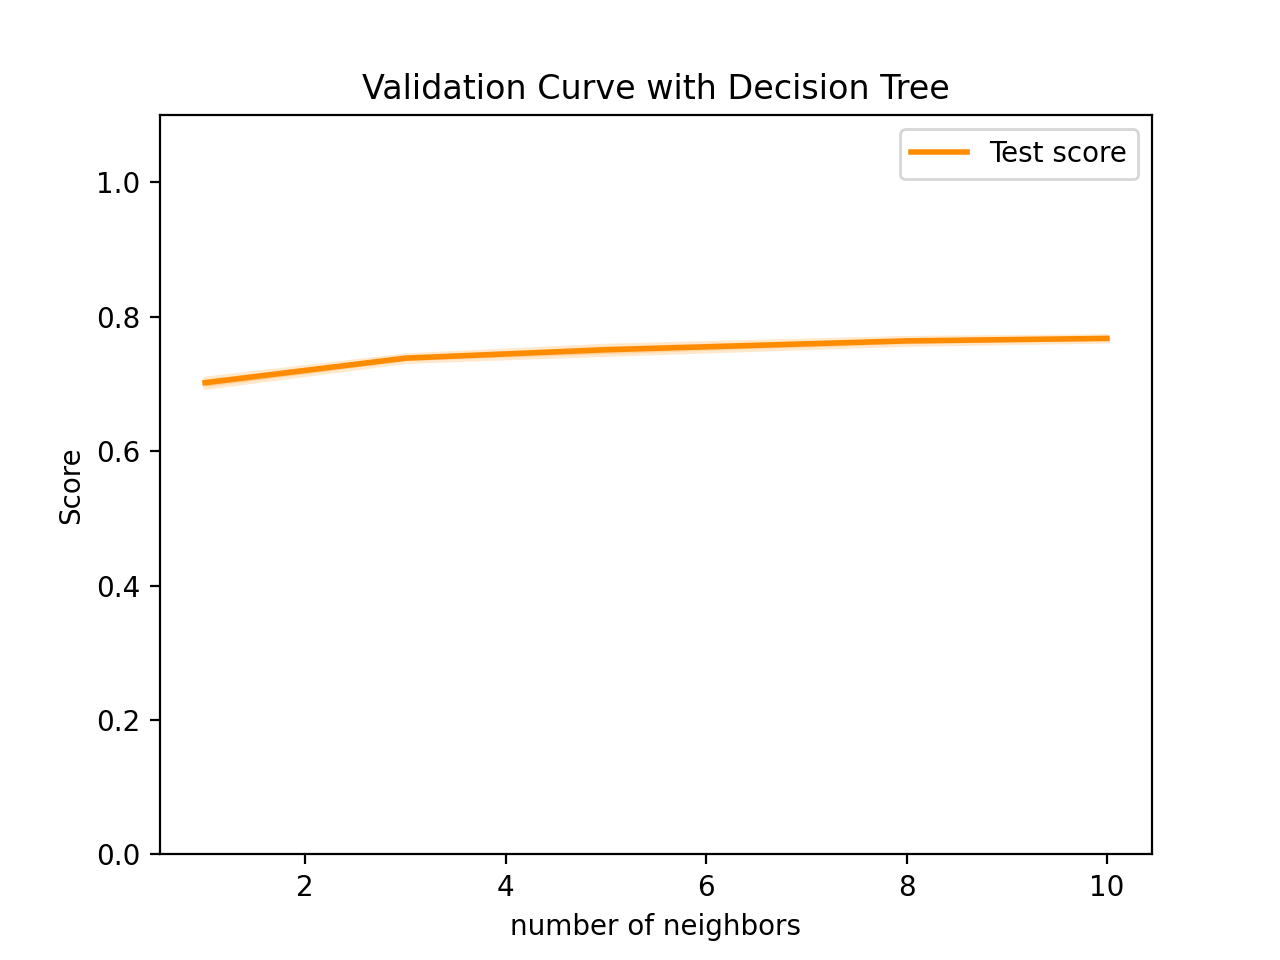

In [152]:
default_pipeline = pipeline_KNN
model_name = "KNN"
param_name = "number of neighbors"
param_range = [1,3,5,8,10]
param_range_number = param_range
# Parameters of pipelines can be set using ‘__’ separated parameter names:
param_grid = {
    'pipeline_KNN__n_neighbors': param_range,
}

search = GridSearchCV(default_pipeline, param_grid, n_jobs=-1)
search.fit(X_train, y_train)
best_pipeline = search.best_estimator_
plot_two_learning_curves(default_pipeline,best_pipeline, model_name, X_train, y_train, ylim=None, cv=None,
                        train_sizes=np.linspace(.1, 1.0, 8))
cv_results = search.cv_results_

plot_validation_curve(cv_results,param_range_number, param_name)

### Comparison of 5 models

<IPython.core.display.Javascript object>


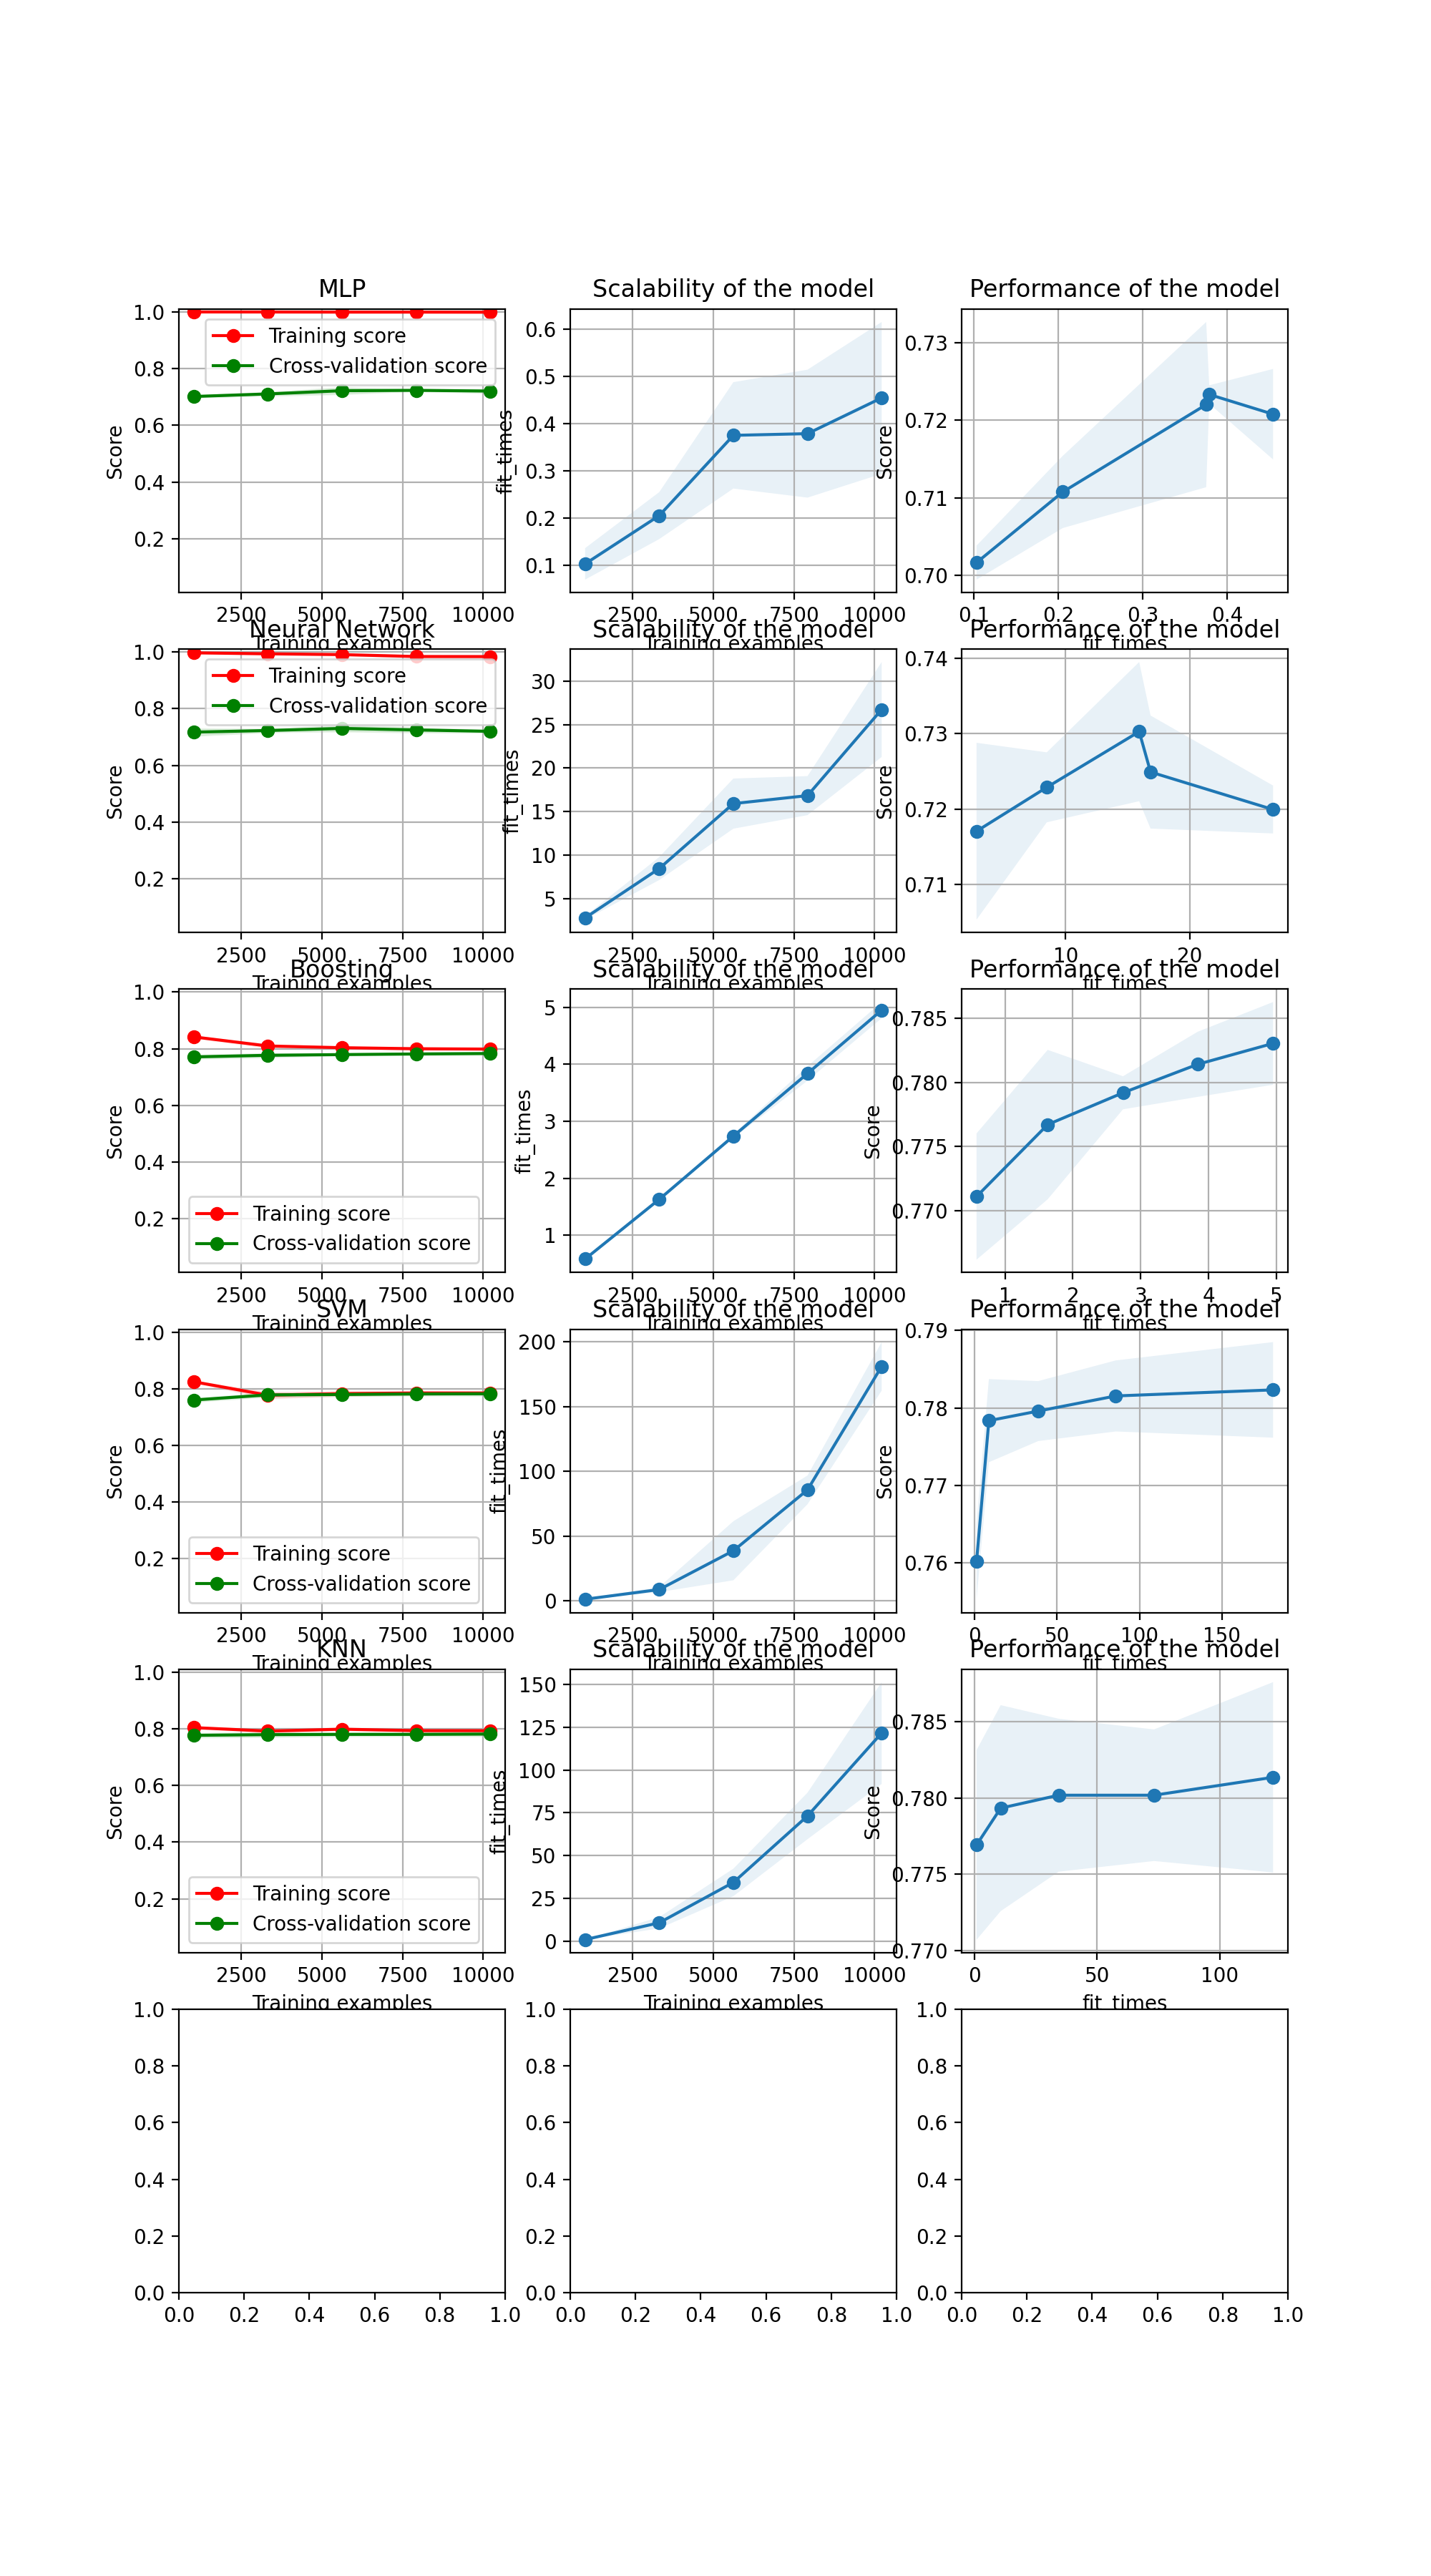

IndexError: list index out of range

In [156]:
titles = ["MLP",'Neural Network','Boosting','SVM','KNN']

# estimator = pipeline_MLP
fig, axes = plt.subplots(6, 3, figsize=(10, 18))
i = 0
for pipe in pipelines:
    plot_learning_curve(pipe, titles[i], X_train, y_train, axes=axes[i,: ], ylim=(0.01, 1.01),
                    cv=3, n_jobs=8)
    i += 1

<IPython.core.display.Javascript object>


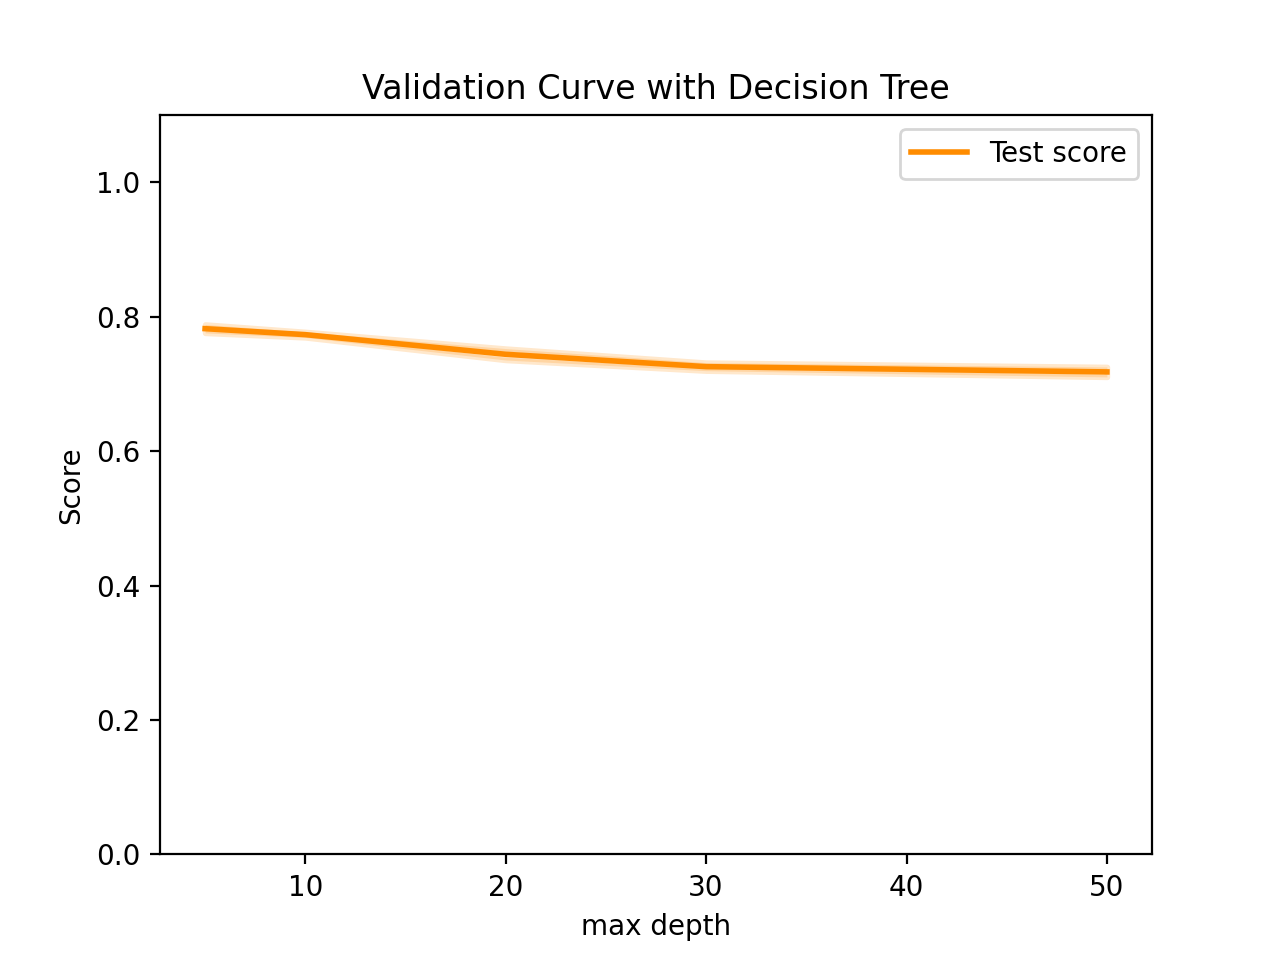

In [147]:
default_pipeline = pipeline_DecisionTree
# Parameters of pipelines can be set using ‘__’ separated parameter names:
param_grid = {
    'pipeline_DecisionTree__max_depth': [5,10,20,30,50],
}


search = GridSearchCV(default_pipeline, param_grid, n_jobs=-1)
search.fit(X_train, y_train)
best_pipeline = search.best_estimator_
plot_two_learning_curves(default_pipeline,best_pipeline, "Decision tree", X_train, y_train, ylim=None, cv=None,
                        train_sizes=np.linspace(.1, 1.0, 8))
cv_results = search.cv_results_
param_range = [5,10,20,30,50]
param_name = "max depth"
plot_validation_curve(cv_results,param_range, param_name)


<IPython.core.display.Javascript object>


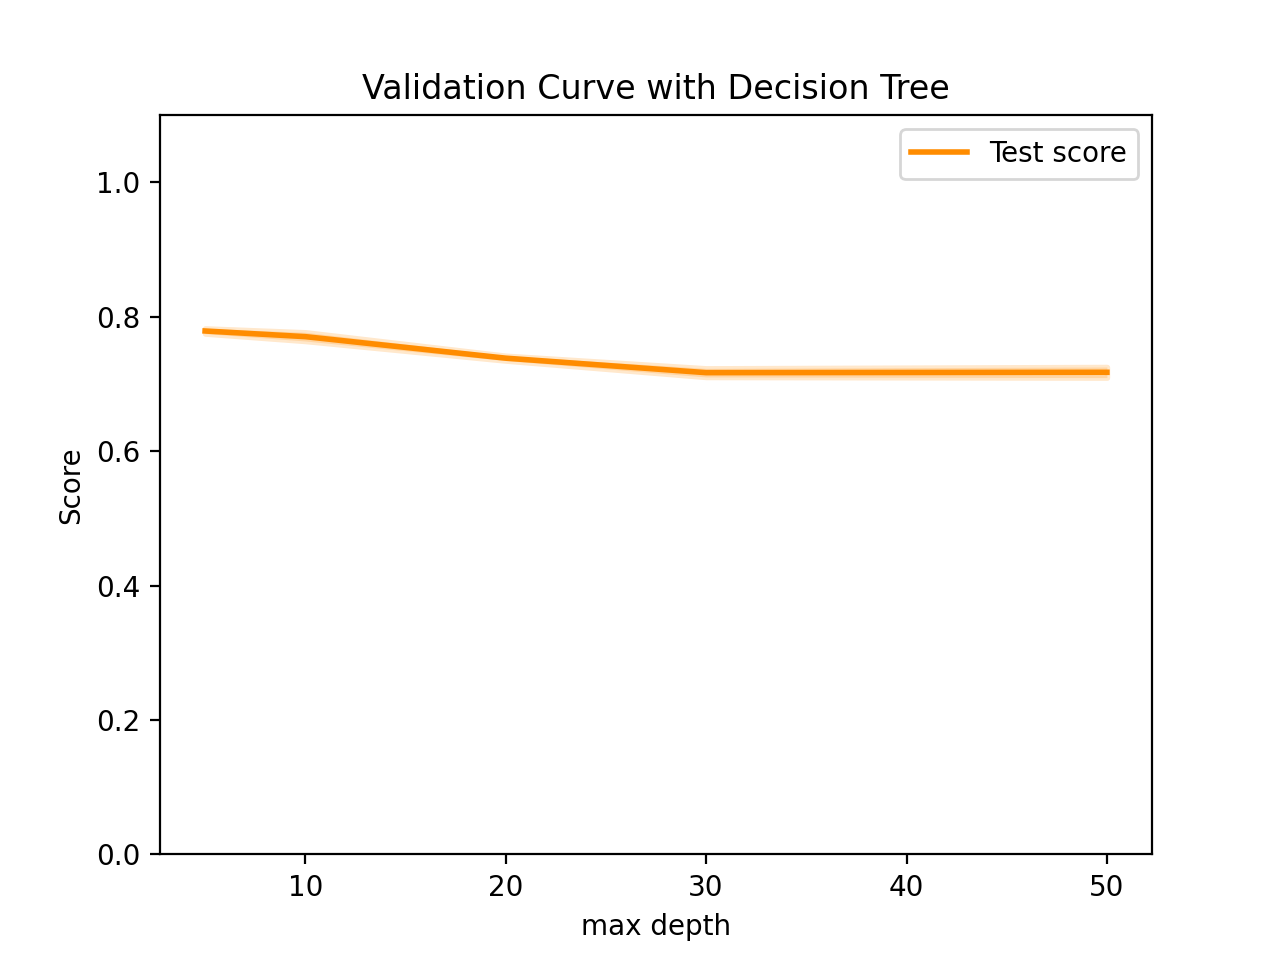

In [102]:
# plot validation curve
mean_test_score = search.cv_results_['mean_test_score']
std_test_score = search.cv_results_['std_test_score']
param_range = [5, 10, 20, 30, 50]
plt.title("Validation Curve with Decision Tree")
plt.xlabel(r"max depth")
plt.ylabel("Score")
plt.ylim(0.0, 1.1)
lw = 2

plt.plot(param_range, mean_test_score, label="Test score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, mean_test_score - std_test_score,
                 mean_test_score + std_test_score, alpha=0.2,
                 color="darkorange", lw=lw)
# plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
#              color="navy", lw=lw)
# plt.fill_between(param_range, test_scores_mean - test_scores_std,
#                  test_scores_mean + test_scores_std, alpha=0.2,
#                  color="navy", lw=lw)
plt.legend(loc="best")
plt.show()

<IPython.core.display.Javascript object>


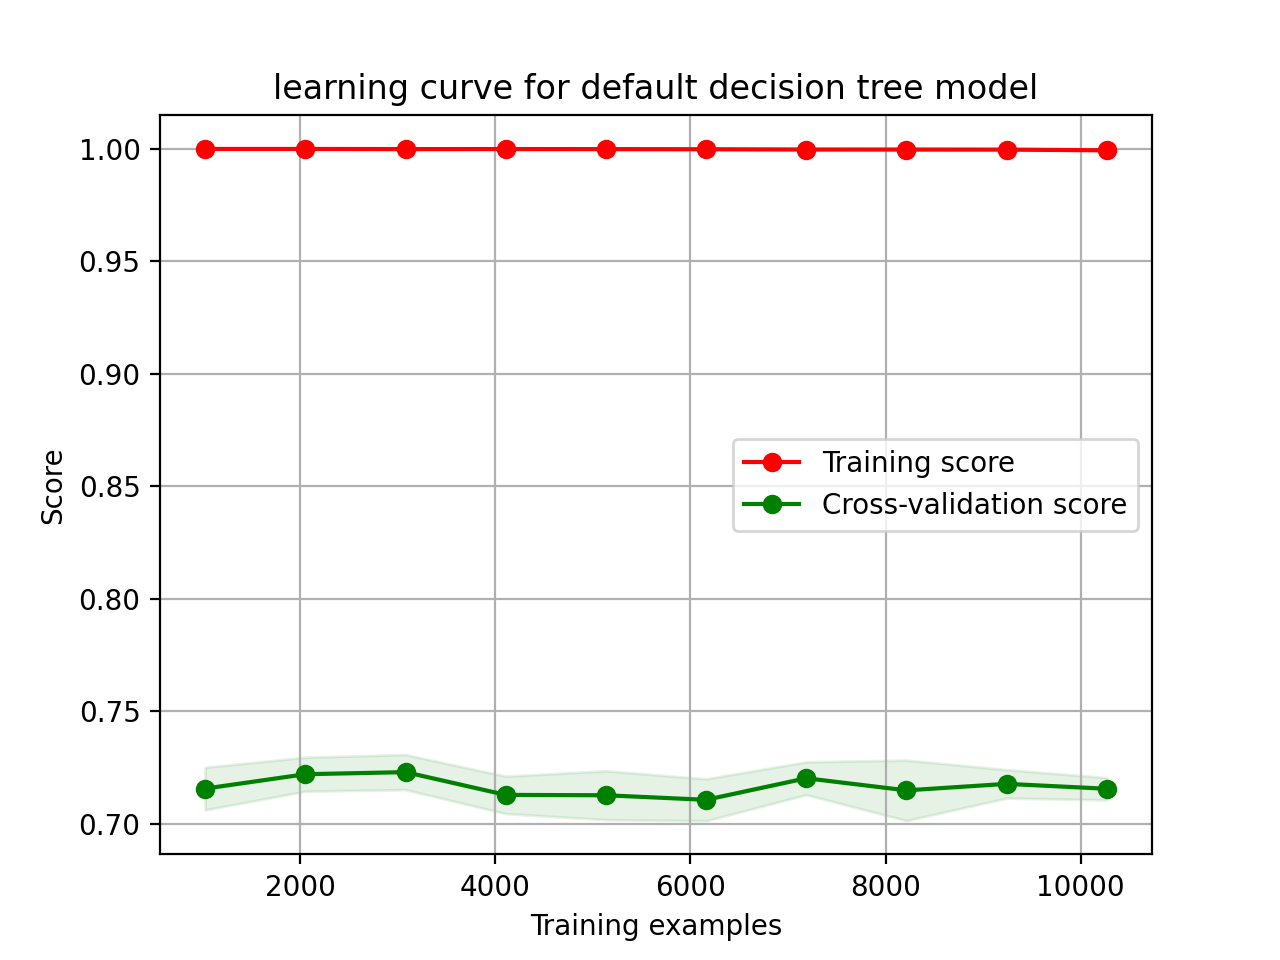

<IPython.core.display.Javascript object>


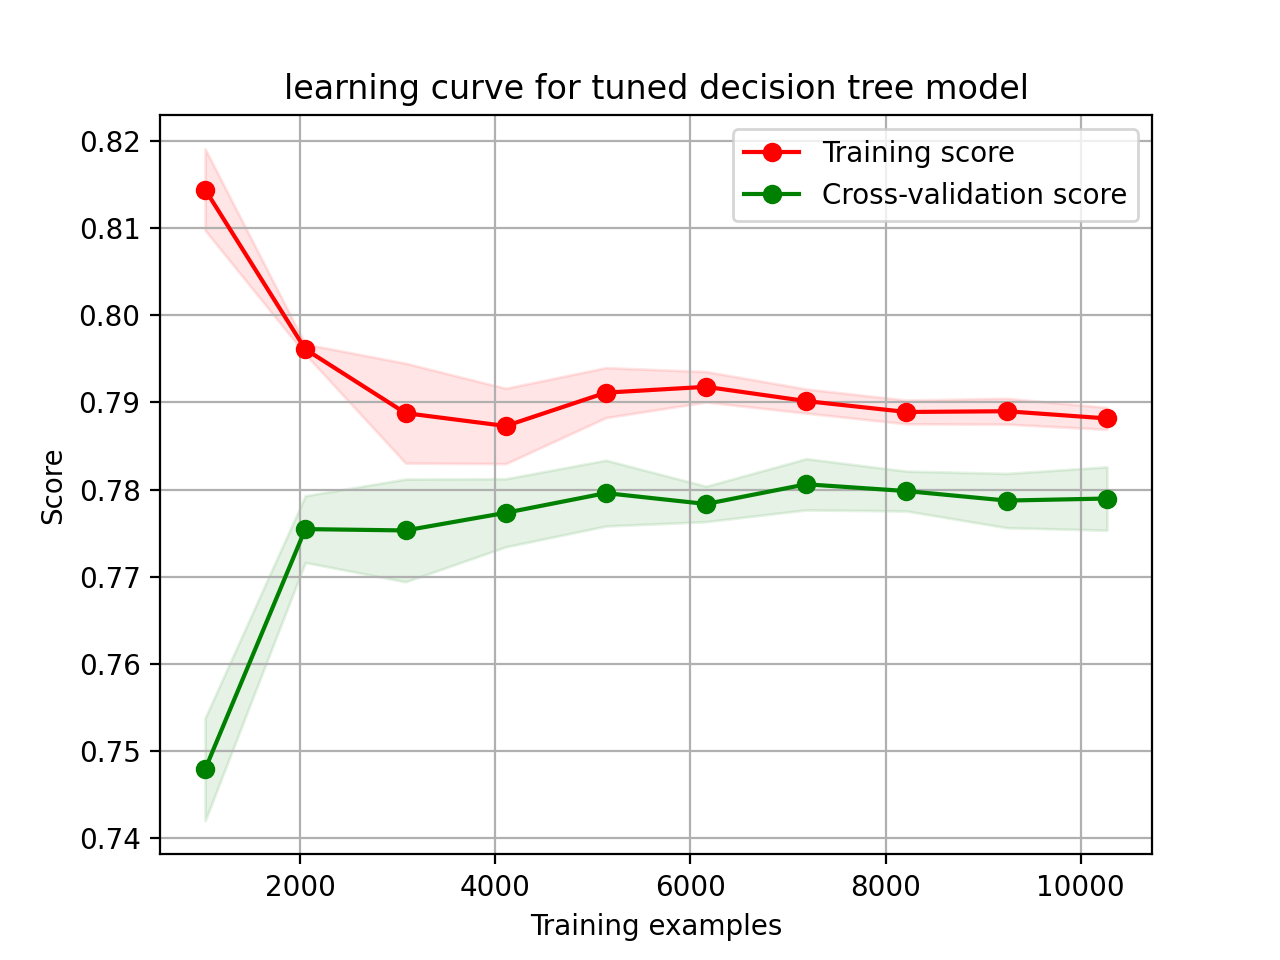

In [114]:
# plot_learning_curve(dt_best, X_train, y_train)
pipe_dt_default = Pipeline([("scaler",StandardScaler()),
                     ("DecisionTree",DecisionTreeClassifier())])
plot_learning_curve(pipe_dt_default, "learning curve for default decision tree model", X_train, y_train, ylim=None, cv=None,
                        train_sizes=np.linspace(.1, 1.0, 10))
plot_learning_curve(dt_best, "learning curve for tuned decision tree model", X_train, y_train, ylim=None, cv=None,
                        train_sizes=np.linspace(.1, 1.0, 10))

<IPython.core.display.Javascript object>


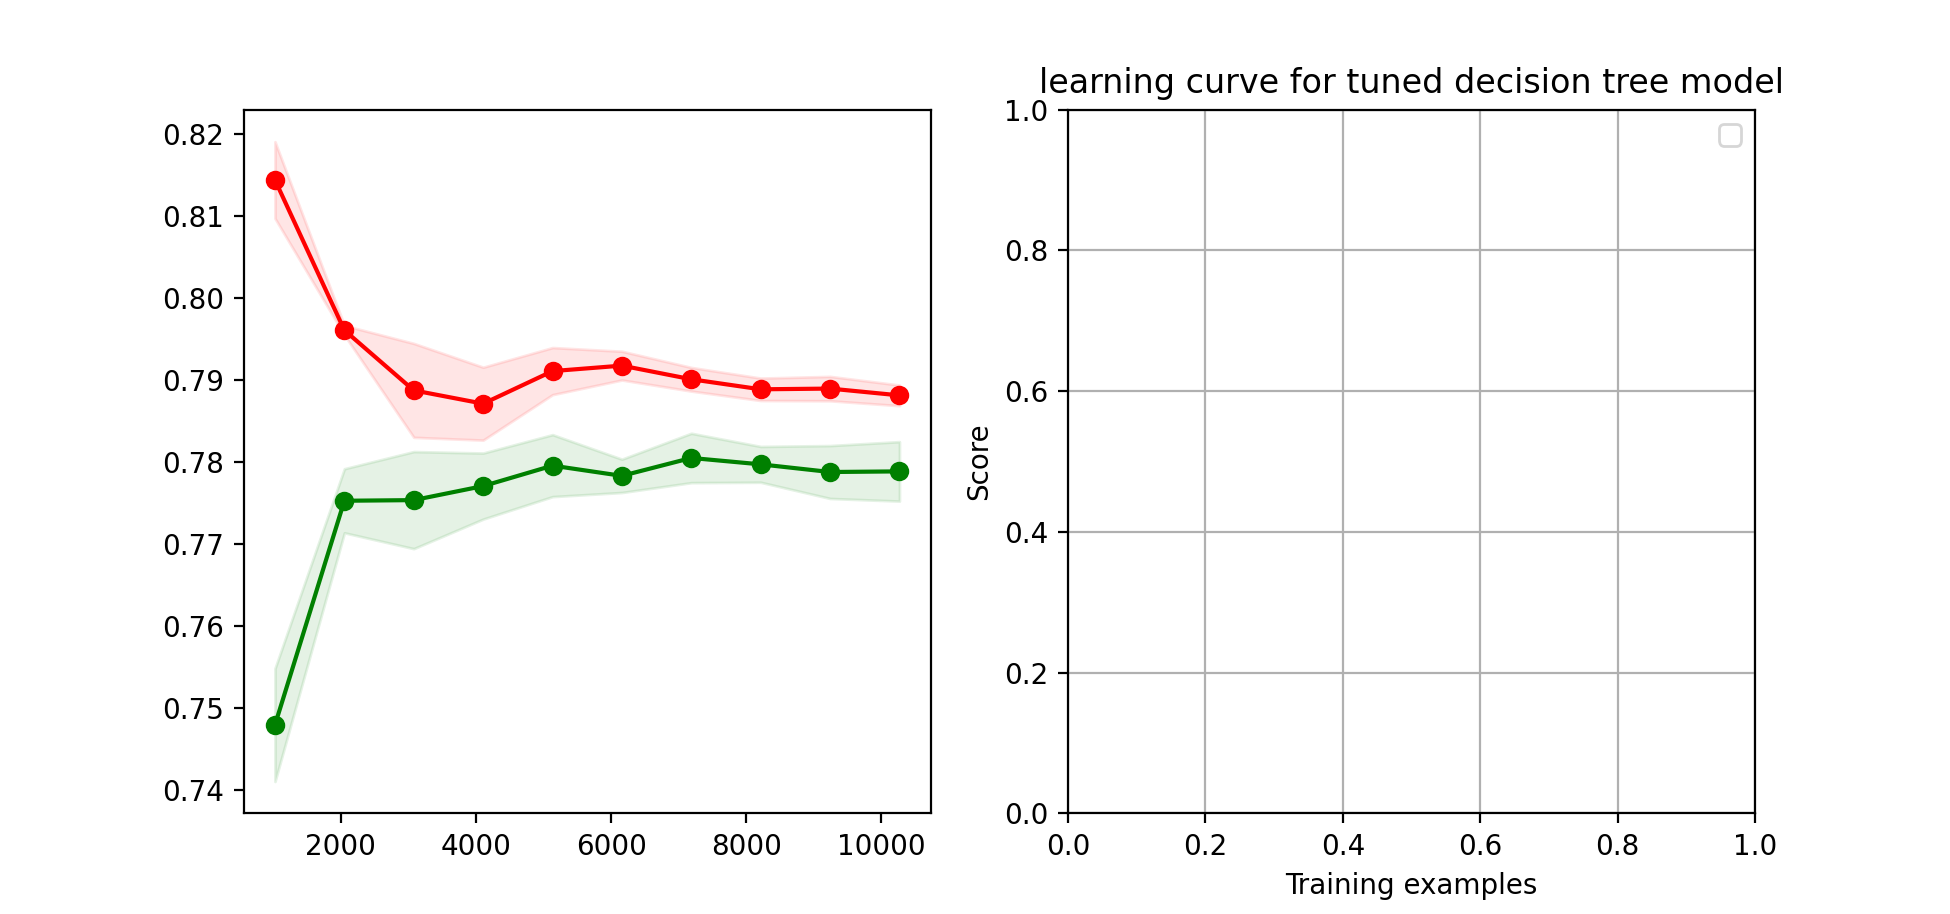

No handles with labels found to put in legend.


In [116]:
plot_two_learning_curves(pipe_dt_default,dt_best, "learning curve for tuned decision tree model", X_train, y_train, ylim=None, cv=None,
                        train_sizes=np.linspace(.1, 1.0, 10))

In [ ]:
plot

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.datasets import load_digits
from sklearn.svm import SVC
from sklearn.model_selection import validation_curve

X, y = load_digits(return_X_y=True)

param_range = np.logspace(-6, -1, 5)
train_scores, test_scores = validation_curve(
    SVC(), X, y, param_name="gamma", param_range=param_range,
    scoring="accuracy", n_jobs=1)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title("Validation Curve with SVM")
plt.xlabel(r"$\gamma$")
plt.ylabel("Score")
plt.ylim(0.0, 1.1)
lw = 2
plt.semilogx(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.show()

In [ ]:
best_param = grid.best_estimator_

In [90]:
pipeline_DecisionTree = Pipeline([("scaler",StandardScaler()),
                     ("pipeline_DecisionTree",DecisionTreeClassifier())])

# neural networks (TODO)
mlp_clf = sklearn.neural_network.MLPClassifier(hidden_layer_sizes=(32,64,32))
pipeline_MLP = Pipeline([("scaler",StandardScaler()), 
                         ("pipeline_MLP",mlp_clf)])
# Boosting
pipeline_GBC = Pipeline([("scaler",StandardScaler()), (
                        "pipeline_GBC",GradientBoostingClassifier())])

# SVM linear
svm_linear = sklearn.svm.SVC(C=1.0, 
                          kernel='linear', 
                          shrinking=True, 
                          probability=False, 
                          tol=0.001, 
                          cache_size=200, 
                          max_iter=- 1, 
                          decision_function_shape='ovr', 
                          break_ties=False, 
                          random_state=None)

svm_rbf = sklearn.svm.SVC(C=1.0, 
                          kernel='rbf', 
                          gamma='scale', 
                          shrinking=True, 
                          probability=False, 
                          tol=0.001, 
                          cache_size=200, 
                          max_iter=- 1, 
                          decision_function_shape='ovr', 
                          break_ties=False, 
                          random_state=None)
pipeline_SVM_Linear = Pipeline([("scaler",StandardScaler()), 
                         ("pipeline_SVM_Linear",svm_linear)
                        ])
# SVM rbf
pipeline_SVM_RBF = Pipeline([("scaler",StandardScaler()), 
                         ("pipeline_SVM_RBF",svm_rbf)
                        ])

# KNN
pipeline_KNN = Pipeline([("scaler",StandardScaler()),
                     ("pipeline_KNN",KNeighborsClassifier())])


# pipeline_GaussianNB = Pipeline([("scaler",StandardScaler()),
#                      ("pipeline_GaussianNB",GaussianNB())])

# pipeline_BernoulliNB = Pipeline([("scaler",StandardScaler()),
#                      ("pipeline_BernoulliNB",BernoulliNB())])

# pipeline_LogisticRegression = Pipeline([("scaler",StandardScaler()),
#                      ("pipeline_LogisticRegression",LogisticRegression())])

# pipeline_RandomForest = Pipeline([("scaler",StandardScaler()),
#                      ("pipeline_RandomForest",RandomForestClassifier())])


# pipeline_KNN = Pipeline([("scaler",StandardScaler()),
#                      ("pipeline_KNN",KNeighborsClassifier())])



# pipeline_SGD = Pipeline([("scaler",StandardScaler()), 
#                         ("pipeline_SGD",SGDClassifier(max_iter=5000, random_state=0))])

# pipeline_LGBM = Pipeline([("scaler",StandardScaler()), 
#                         ("pipeline_NN",lightgbm.LGBMClassifier())])

pipelines = [pipeline_DecisionTree,
             pipeline_MLP,
             pipeline_GBC,
             pipeline_SVM_Linear,
             pipeline_SVM_RBF,
             pipeline_KNN
            ]
             

pipe_dict = {0: "DecisionTreeClassifier",
             1: "MLP", 
             2: "GBC",
             3: "SVM_Linear", 
             4: "SVM_RBF",
             5: "KNN"
            }

modelNames = ["DecisionTreeClassifier",
             "MLP", 
             "GBC",
             "SVM_Linear", 
             "SVM_RBF",
             "KNN"
             ]




In [91]:
i= 0
trainScores = []
validationScores = []
testScores = []

for pipe in pipelines:
    pipe.fit(X_train, y_train)
    print(f'{pipe_dict[i]}')
    print("Train Score of %s: %f     " % (pipe_dict[i], pipe.score(X_train, y_train)*100))
    trainScores.append(pipe.score(X_train, y_train)*100)
    
    print("Validation Score of %s: %f" % (pipe_dict[i], pipe.score(X_valid, y_valid)*100))
    validationScores.append(pipe.score(X_valid, y_valid)*100)
    
    print("Test Score of %s: %f      " % (pipe_dict[i], pipe.score(X_test, y_test)*100))
    testScores.append(pipe.score(X_test, y_test)*100)
    print(" ")
    
    y_predictions = pipe.predict(X_test)
    conf_matrix = confusion_matrix(y_predictions, y_test)
    print(f'Confussion Matrix: \n{conf_matrix}\n')
    
    tn = conf_matrix[0,0]
    fp = conf_matrix[0,1]
    tp = conf_matrix[1,1]
    fn = conf_matrix[1,0]

    total = tn + fp + tp + fn
    real_positive = tp + fn
    real_negative = tn + fp

    accuracy  = (tp + tn) / total # Accuracy Rate
    precision = tp / (tp + fp) # Positive Predictive Value
    recall    = tp / (tp + fn) # True Positive Rate
    f1score  = 2 * precision * recall / (precision + recall)
    specificity = tn / (tn + fp) # True Negative Rate
    error_rate = (fp + fn) / total # Missclassification Rate
    prevalence = real_positive / total
    miss_rate = fn / real_positive # False Negative Rate
    fall_out = fp / real_negative # False Positive Rate
    
    print('Evaluation Metrics:')
    print(f'Accuracy    : {accuracy}')
    print(f'Precision   : {precision}')
    print(f'Recall      : {recall}')
    print(f'F1 score    : {f1score}')
    print(f'Specificity : {specificity}')
    print(f'Error Rate  : {error_rate}')
    print(f'Prevalence  : {prevalence}')
    print(f'Miss Rate   : {miss_rate}')
    print(f'Fall Out    : {fall_out}')

    print("") 
    print(f'Classification Report: \n{classification_report(y_predictions, y_test)}\n')
    print("")

    print("*****"*20)
    i +=1

DecisionTreeClassifier
Train Score of DecisionTreeClassifier: 99.922088     
Validation Score of DecisionTreeClassifier: 73.141411
Test Score of DecisionTreeClassifier: 71.916509      
 
Confussion Matrix: 
[[1918  425]
 [ 463  356]]

Evaluation Metrics:
Accuracy    : 0.7191650853889943
Precision   : 0.4558258642765685
Recall      : 0.4346764346764347
F1 score    : 0.445
Specificity : 0.8186086214255228
Error Rate  : 0.2808349146110057
Prevalence  : 0.25901328273244784
Miss Rate   : 0.5653235653235653
Fall Out    : 0.18139137857447715

Classification Report: 
              precision    recall  f1-score   support

         0.0       0.81      0.82      0.81      2343
         1.0       0.46      0.43      0.45       819

    accuracy                           0.72      3162
   macro avg       0.63      0.63      0.63      3162
weighted avg       0.71      0.72      0.72      3162



****************************************************************************************************
MLP


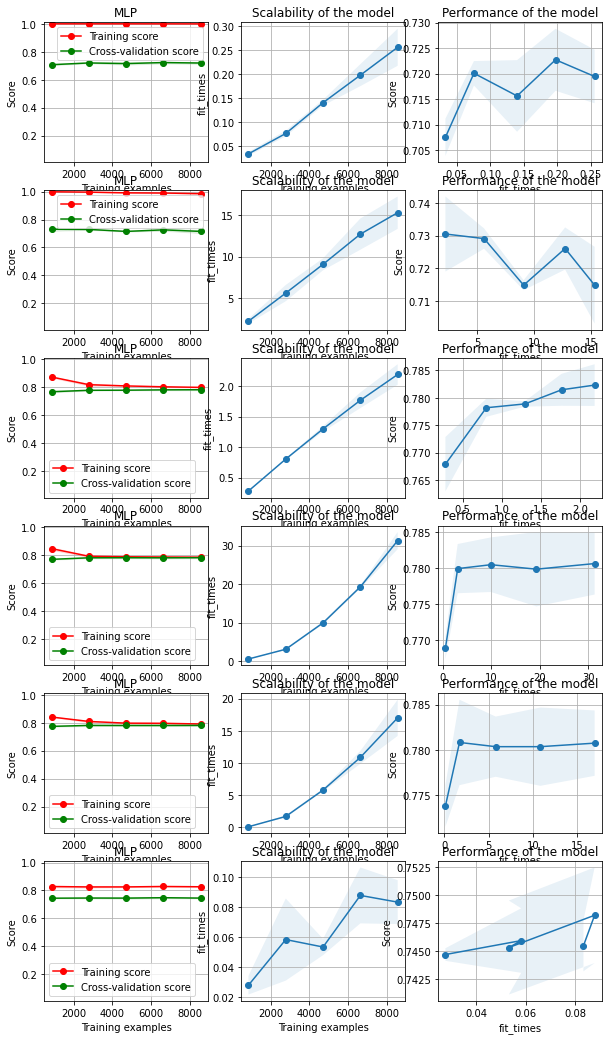

In [93]:
title = "MLP"
estimator = pipeline_MLP
fig, axes = plt.subplots(6, 3, figsize=(10, 18))
i = 0
for pipe in pipelines:
    plot_learning_curve(pipe, title, X_train, y_train, axes=axes[i,: ], ylim=(0.01, 1.01),
                    cv=3, n_jobs=8)
    i += 1